In [1]:
import matplotlib.pyplot as plt
import movecolumn as mc
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

plt.rcParams['figure.figsize'] = [14, 3]


# Предобработка данных

Dataset from: https://github.com/itmo-ml-lab-ML-course/parser-imorda

In [2]:
raw_df = pd.read_csv('data/result.csv')
raw_df

Unnamed: 0                         name body_type modification_name  \
0               0        Nissan Gloria X (Y33)     Седан            2.0 AT   
1               1        Nissan Gloria X (Y33)     Седан            2.5 AT   
2               2        Nissan Gloria X (Y33)     Седан            2.5 AT   
3               3        Nissan Gloria X (Y33)     Седан            3.0 AT   
4               4        Nissan Gloria X (Y33)     Седан            3.0 AT   
...           ...                          ...       ...               ...   
58279       58279  Toyota Avensis I Рестайлинг   Лифтбек            2.0 AT   
58280       58280            Toyota Avensis II     Седан            2.2 MT   
58281       58281            Toyota Avensis II   Лифтбек            1.8 AT   
58282       58282            Toyota Avensis II     Седан            2.2 MT   
58283       58283  Toyota Avensis I Рестайлинг   Лифтбек            2.0 AT   

       price_min  price_max country classe  doors_count  seats_count  ...  \
0             -1         -1  Япония      E            4            5  ...   
1         230000     230000  Япония      E            4            5  ...   
2             -1         -1  Япония      E            4            5  ...   
3             -1         -1  Япония      E            4            5  ...   
4             -1         -1  Япония      E            4            5  ...   
...          ...        ...     ...    ...          ...          ...  ...   
58279         -1         -1  Япония      D            5            5  ...   
58280         -1         -1  Япония      D            4            5  ...   
58281         -1         -1  Япония      D            5            5  ...   
58282         -1         -1  Япония      D            4            5  ...   
58283         -1         -1  Япония      D            5            5  ...   

      engine_max_power_rpm engine_max_torque engine_max_torque_rpm  \
0                     6000               167                  3200   
1                     6400               235                  4000   
2                     6400               275                  4800   
3                     5200               248                  3200   
4                     6000               368                  3600   
...                    ...               ...                   ...   
58279                 5700               200                  4000   
58280                 3600               310                  2000   
58281                 6000               170                  4200   
58282                 3600               310                  2000   
58283                 5400               178                  4400   

      engine_cylinders_position engine_cylinders_count  \
0                    V-образное                      6   
1                    V-образное                      6   
2                        рядное                      6   
3                    V-образное                      6   
4                    V-образное                      6   
...                         ...                    ...   
58279                    рядное                      4   
58280                    рядное                      4   
58281                    рядное                      4   
58282                    рядное                      4   
58283                    рядное                      4   

       engine_valves_per_cylinder                     engine_intake_type  \
0                              -1  распределенный впрыск (многоточечный)   
1                               4  распределенный впрыск (многоточечный)   
2                               4  распределенный впрыск (многоточечный)   
3                               2  распределенный впрыск (многоточечный)   
4                               4       непосредственный впрыск (прямой)   
...                           ...                                    ...   
58279                           4  распределенный впрыск (многоточечный)   

Кайф, 54 параметра. Предстоит найти в них небесполезные признаки....

Попробуем предсказывать цену автомобиля по его каталожным параметрам

<Axes: >

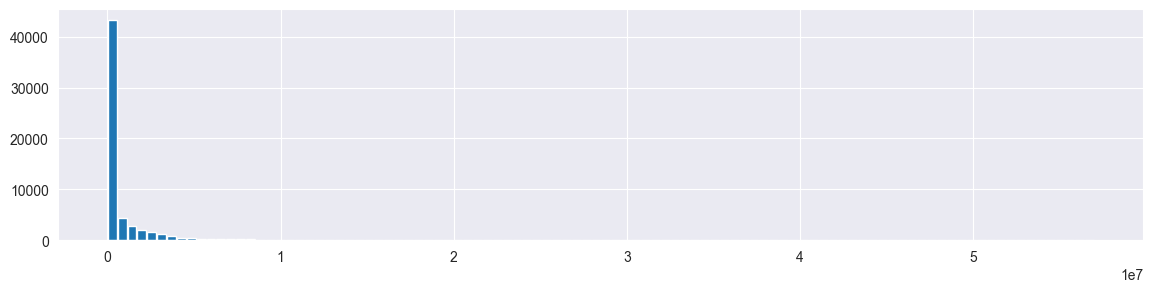

In [3]:
raw_df.price_min.hist(bins=100, rwidth=0.9)

Для начала потрём данные, в которых нет цены, так как её и будем предсказывать (как в train, так и в test выборке нужна цена, надо же как-то что-то валидировать

Замечание: как price_min так и price_max могут быть страшными выбросами, так как низ рынка, как и верх иногда могут неоправдано улетать в космос. Хочется взять медиану рынка, но у нас всего 2 признака (мин и макс). Что ж, остаётся только взять среднее, чтобы хоть как-то с этим справиться.


<Axes: >

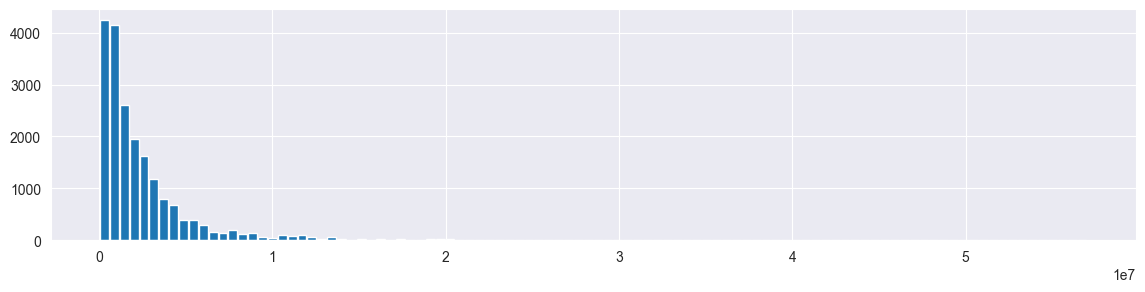

In [4]:
raw_df['price_avg'] = raw_df.price_min + (raw_df.price_max - raw_df.price_min) / 2.

df = raw_df[(raw_df.price_min > 0) &
            (raw_df.price_max > 0) &
            (raw_df.doors_count > 0)]
df.price_avg.hist(bins=100, rwidth=0.9)

In [5]:
df

Unnamed: 0                    name body_type modification_name  \
1               1   Nissan Gloria X (Y33)     Седан            2.5 AT   
9               9   Nissan Gloria X (Y33)     Седан            2.8 AT   
60             60  Nissan Gloria XI (Y34)     Седан            3.0 AT   
63             63  Nissan Gloria XI (Y34)     Седан           3.0 CVT   
64             64  Nissan Gloria XI (Y34)     Седан            2.5 AT   
...           ...                     ...       ...               ...   
58264       58264       Toyota Avensis II     Седан            1.8 AT   
58266       58266       Toyota Avensis II     Седан            2.0 MT   
58267       58267       Toyota Avensis II     Седан            2.0 AT   
58268       58268       Toyota Avensis II     Седан            1.8 MT   
58275       58275       Toyota Avensis II     Седан            2.0 AT   

       price_min  price_max country classe  doors_count  seats_count  ...  \
1         230000     230000  Япония      E            4            5  ...   
9         820000     820000  Япония      E            4            5  ...   
60        510000     510000  Япония      E            4            5  ...   
63        510000     510000  Япония      E            4            5  ...   
64        548000     690000  Япония      E            4            5  ...   
...          ...        ...     ...    ...          ...          ...  ...   
58264     600000     600000  Япония      D            4            5  ...   
58266     610000     610000  Япония      D            4            5  ...   
58267     610000     610000  Япония      D            4            5  ...   
58268     600000     600000  Япония      D            4            5  ...   
58275     610000     610000  Япония      D            4            5  ...   

      engine_max_torque engine_max_torque_rpm engine_cylinders_position  \
1                   235                  4000                V-образное   
9                   181                  2400                    рядное   
60                  387                  3600                V-образное   
63                  387                  3600                V-образное   
64                  265                  4400                V-образное   
...                 ...                   ...                       ...   
58264               170                  4200                    рядное   
58266               196                  4000                    рядное   
58267               196                  4000                    рядное   
58268               170                  4200                    рядное   
58275               192                  4000                    рядное   

      engine_cylinders_count engine_valves_per_cylinder  \
1                          6                          4   
9                          6                          2   
60                         6                          4   
63                         6                          4   
64                         6                          4   
...                      ...                        ...   
58264                      4                          4   
58266                      4                          4   
58267                      4                          4   
58268                      4                          4   
58275                      4                          4   

                          engine_intake_type  engine_compression  \
1      распределенный впрыск (многоточечный)                10.0   
9                              ТНВД (Дизель)                22.0   
60          непосредственный впрыск (прямой)                 9.0   
63          непосредственный впрыск (прямой)                 9.0   
64          непосредственный впрыск (прямой)                11.0   
...                                      ...                 ...   
58264  распределенный впрыск (многоточечный)                10.0   
58266       непосредственный впрыск (прямой)       

Слишком большой разброс цен, ничего не видно. Окэй, логарифмируем

<Axes: >

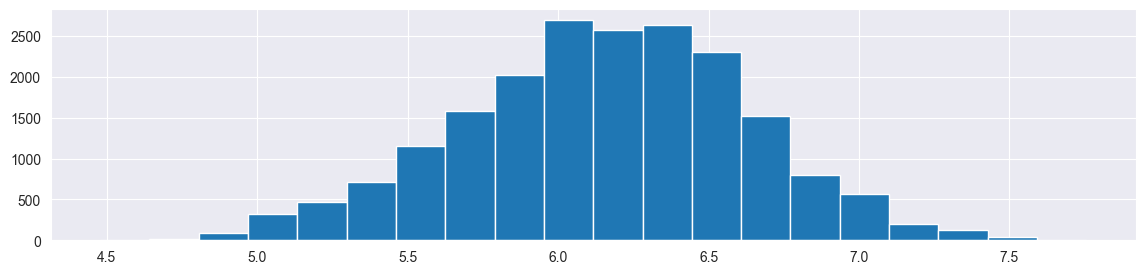

In [6]:
price = df.price_avg
price_log = np.log10(price)
price_log.hist(bins=20)

Omg, это же нормальное распределение, кайф. 
Ну мы поняли, что большинство тачек стоит где-то 1-5 лимонов, супер.

Лан, это вполне возможно предсказывать. 

Теперь задача вытащить из этой свалки полезные фичи...

In [7]:
df.dtypes

Unnamed: 0                      int64
name                           object
body_type                      object
modification_name              object
price_min                       int64
price_max                       int64
country                        object
classe                         object
doors_count                     int64
seats_count                     int64
steering_wheel_side            object
front_suspension_type          object
rear_suspension_type           object
front_brakes_type              object
rear_brakes_type               object
length                          int64
width                           int64
height                          int64
wheelbase                       int64
clearance                       int64
front_track                     int64
rear_track                      int64
max_speed                       int64
zero_to_100                   float64
fuel_consumption_city         float64
fuel_consumption_road         float64
fuel_consump

В целом, можно парсить и onehotить имя, вытаскивая название марки. Всякие мерседесы ожидаются быть более дорогими, чем ВАЗ. Однако, это довольно тупая фича получается, так как мы не можем ограничиться парой марок, лучше смотреть на более прямые признаки (например, класс автомобиля, который в свою очередь не помешает отonehotить)

In [8]:
processed_df = pd.DataFrame()

### Численные признаки

#### Количество дверей

<Axes: >

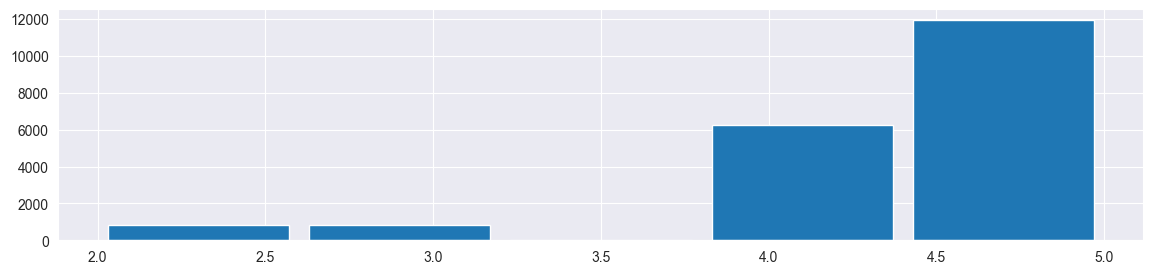

In [9]:
processed_df['doors_count'] = df.doors_count
processed_df.doors_count.hist(bins=5, rwidth=0.9)

#### Количество мест

<Axes: >

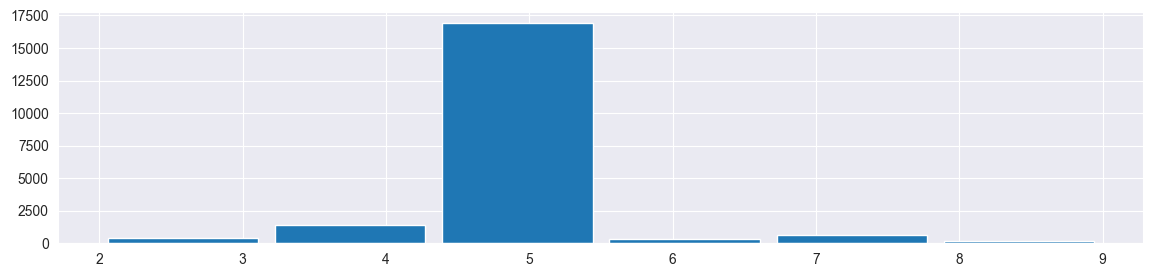

In [10]:
processed_df['seats_count'] = df.seats_count
processed_df.seats_count.hist(bins=6, rwidth=0.9)

#### Длина

<Axes: >

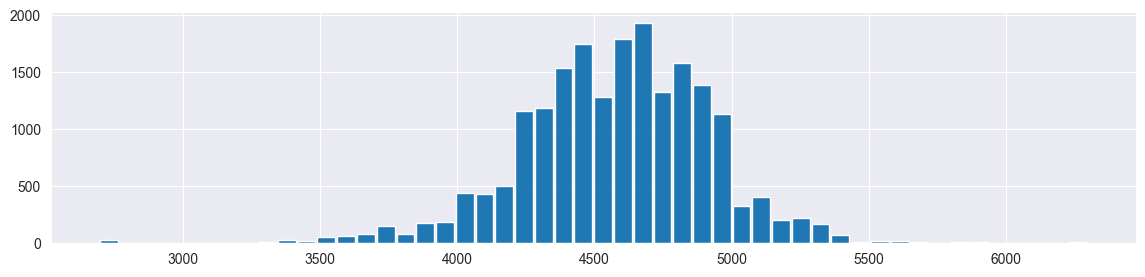

In [11]:
processed_df['length'] = df.length
processed_df.length.hist(bins=50, rwidth=0.9)

#### Ширина

<Axes: >

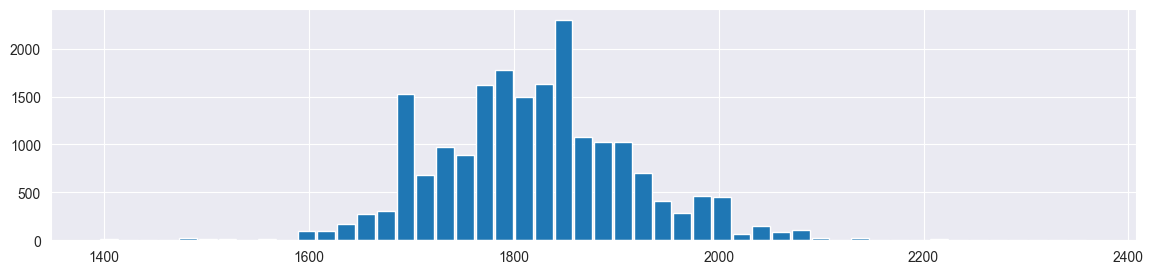

In [12]:
processed_df['width'] = df.width
processed_df.width.hist(bins=50, rwidth=0.9)

#### Высота

<Axes: >

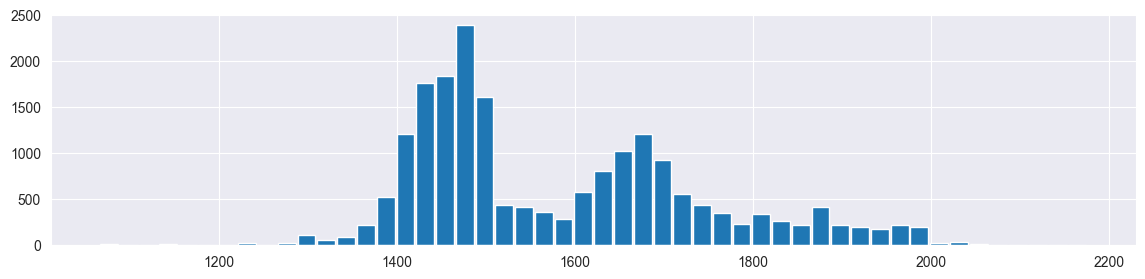

In [13]:
processed_df['height'] = df.height
processed_df.height.hist(bins=50, rwidth=0.9)

#### Колёсная база

<Axes: >

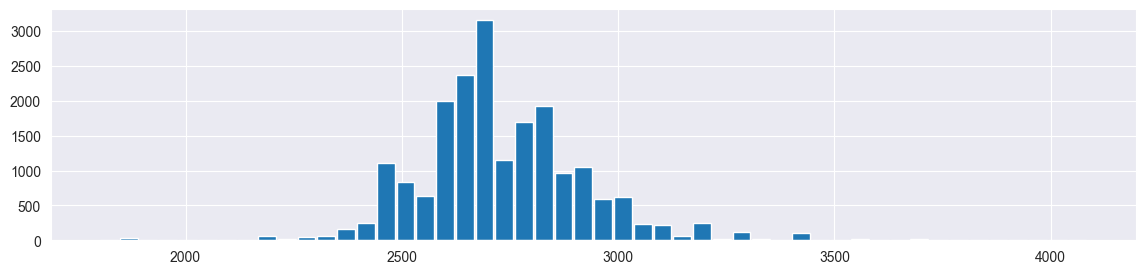

In [14]:
processed_df['wheelbase'] = df.wheelbase
processed_df.wheelbase.hist(bins=50, rwidth=0.9)

#### Клиренс

<Axes: >

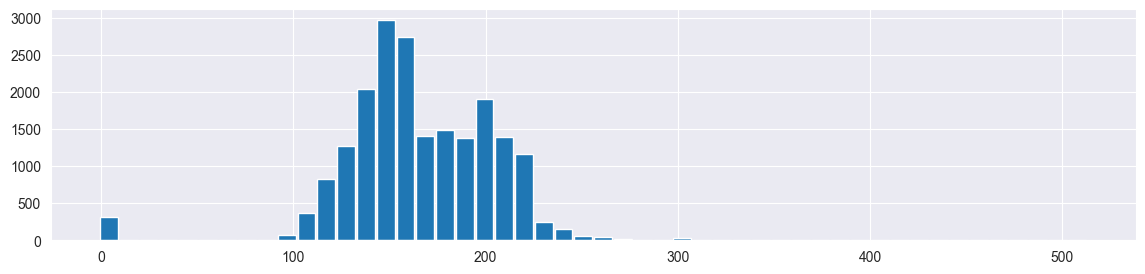

In [15]:
processed_df['clearance'] = df.clearance
processed_df.clearance.hist(bins=50, rwidth=0.9)

#### Передняя колея

<Axes: >

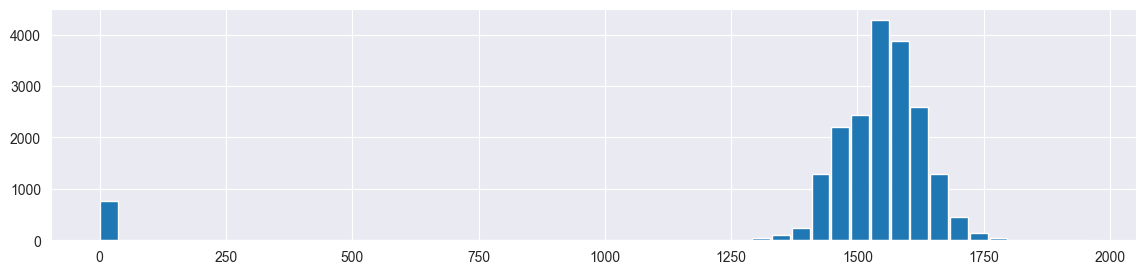

In [16]:
processed_df['front_track'] = df.front_track
processed_df.front_track.hist(bins=50, rwidth=0.9)

#### Задняя колея

<Axes: >

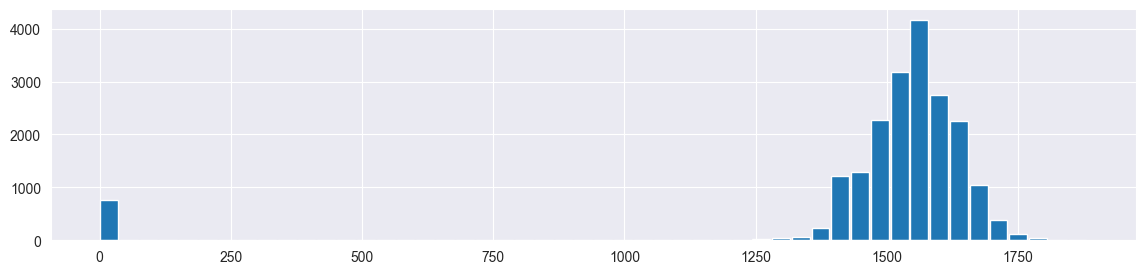

In [17]:
processed_df['rear_track'] = df.rear_track
processed_df.rear_track.hist(bins=50, rwidth=0.9)

#### Максимальная скорость

<Axes: >

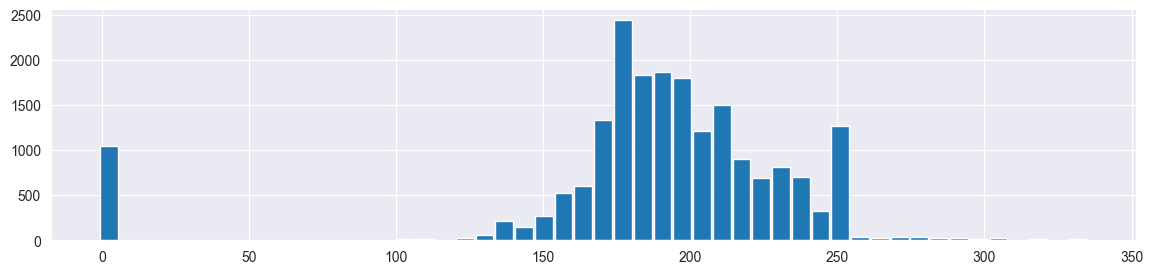

In [18]:
processed_df['max_speed'] = df.max_speed
processed_df.max_speed.hist(bins=50, rwidth=0.9)

#### Разгон до 100

<Axes: >

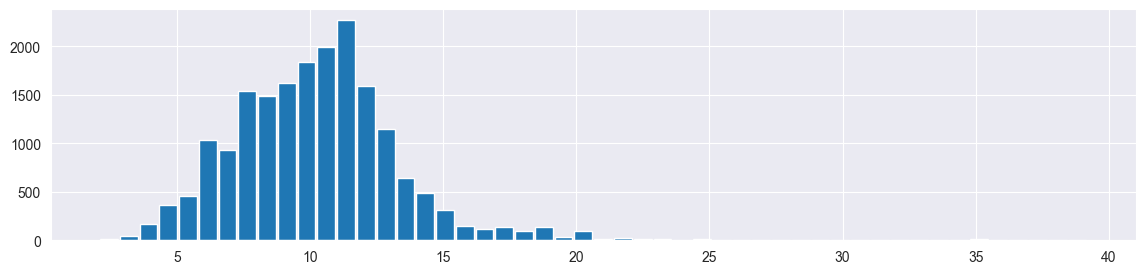

In [19]:
processed_df['zero_to_100'] = df.zero_to_100
processed_df.zero_to_100.hist(bins=50, rwidth=0.9)

#### Смешанный расход топлива

<Axes: >

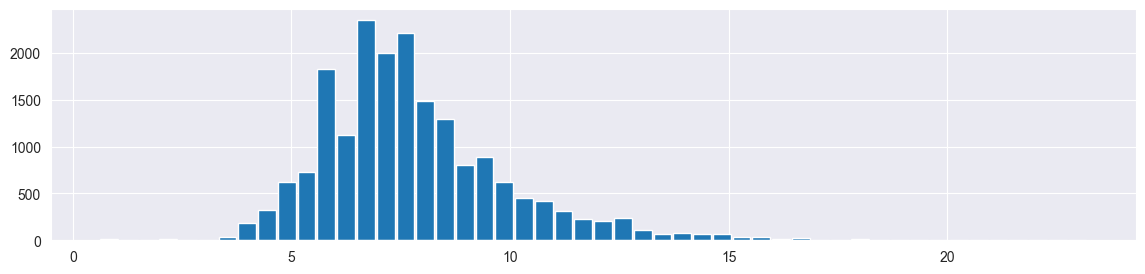

In [20]:
processed_df['fuel_consumption_mixed'] = df.fuel_consumption_mixed
processed_df.fuel_consumption_mixed.hist(bins=50, rwidth=0.9)

#### Объём двигателя

<Axes: >

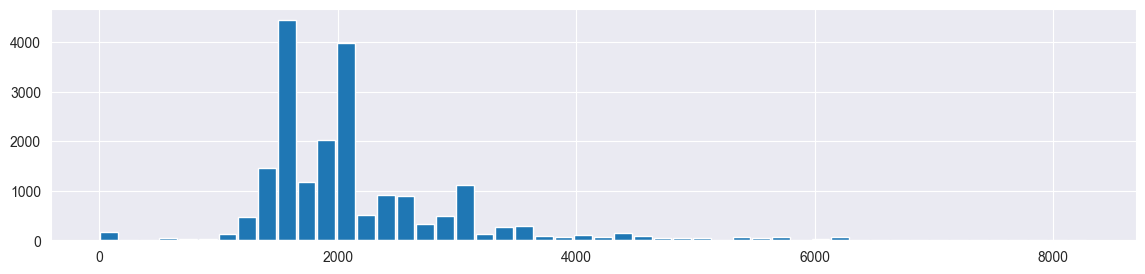

In [21]:
processed_df['engine_displacement'] = df.engine_displacement
processed_df.engine_displacement.hist(bins=50, rwidth=0.9)

#### Мощность двигателя

<Axes: >

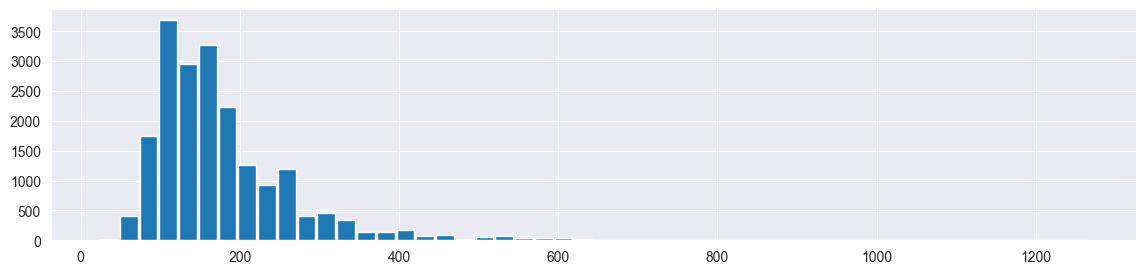

In [22]:
processed_df['engine_max_horsepower'] = df.engine_max_horsepower
processed_df.engine_max_horsepower.hist(bins=50, rwidth=0.9)

#### Крутящий момент двигателя

<Axes: >

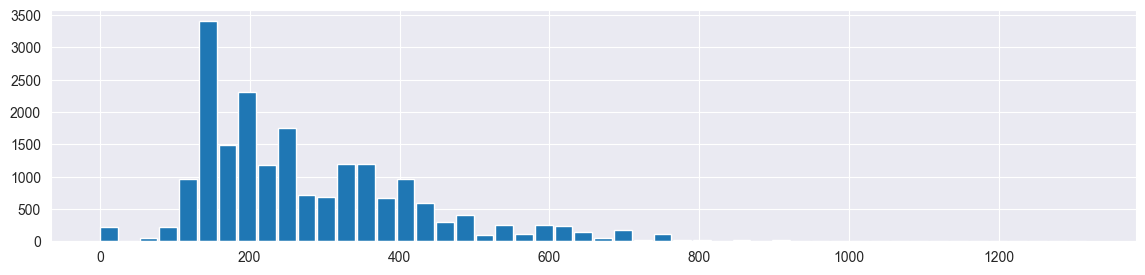

In [23]:
processed_df['engine_max_torque'] = df.engine_max_torque
processed_df.engine_max_torque.hist(bins=50, rwidth=0.9)

#### Количество цилиндров в двигателе

<Axes: >

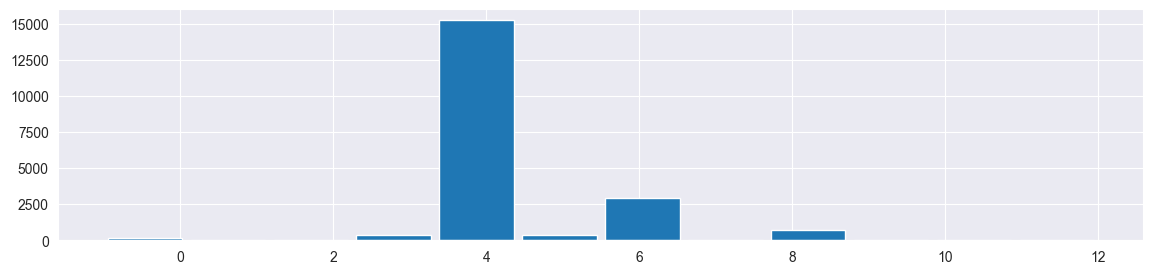

In [24]:
processed_df['engine_cylinders_count'] = df.engine_cylinders_count
processed_df.engine_cylinders_count.hist(bins=12, rwidth=0.9)

#### Средняя цена

<Axes: >

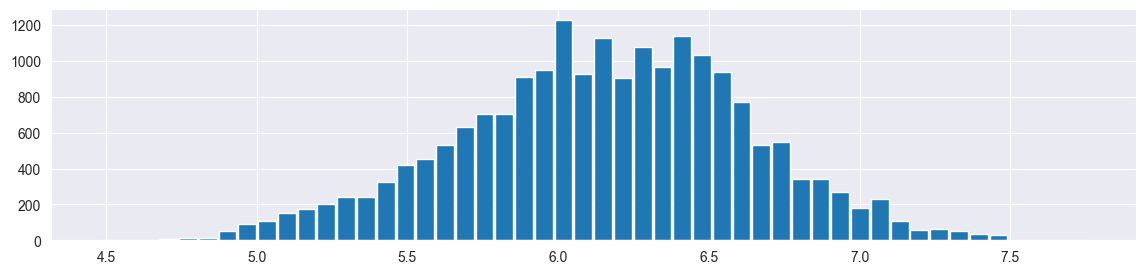

In [25]:
processed_df['price_avg'] = price_log
processed_df.price_avg.hist(bins=50, rwidth=0.9)

### Target

#### Тип привода

Тут хотим сделать label encoding, чтобы сделать из этого признака target. Хорошо ложится на kNN, где не бывает промежуточных значений результата

In [26]:
le = LabelEncoder()
le.fit(df.drive_type)
le.classes_

array(['задний', 'передний', 'полный'], dtype=object)

In [27]:
processed_df['target'] = le.transform(df.drive_type)
processed_df

doors_count  seats_count  length  width  height  wheelbase  clearance  \
1                4            5    4860   1720    1425       2735        145   
9                4            5    4860   1720    1425       2735        145   
60               4            5    4865   1770    1180       2800        140   
63               4            5    4865   1770    1180       2800        140   
64               4            5    4865   1770    1180       2800        140   
...            ...          ...     ...    ...     ...        ...        ...   
58264            4            5    4630   1760    1480       2700        150   
58266            4            5    4630   1760    1480       2700        150   
58267            4            5    4630   1760    1480       2700        150   
58268            4            5    4630   1760    1480       2700        150   
58275            4            5    4630   1760    1480       2700        150   

       front_track  rear_track  max_speed  zero_to_100  \
1             1440        1450         -1          NaN   
9             1440        1450         -1          NaN   
60            1510        1510        251          6.8   
63            1510        1510        245          6.6   
64            1510        1510        180          8.8   
...            ...         ...        ...          ...   
58264         1505        1510        185         11.6   
58266         1505        1510        205          9.4   
58267         1505        1510        195         11.1   
58268         1505        1510        200         10.3   
58275         1505        1510         -1         11.9   

       fuel_consumption_mixed  engine_displacement  engine_max_horsepower  \
1                         9.0                 2495                    190   
9                         NaN                 2825                    100   
60                       11.0                 2960                    280   
63                       11.0                 2960                    280   
64                        8.5                 2495                    210   
...                       ...                  ...                    ...   
58264                     7.7                 1794                    129   
58266                     8.0                 1998                    147   
58267                     9.2                 1998                    147   
58268                     7.2                 1794                    129   
58275                     7.7                 1998                    155   

       engine_max_torque  engine_cylinders_count  price_avg  target  
1                    235                       6   5.361728       0  
9                    181                       6   5.913814       0  
60                   387                       6   5.707570       0  
63                   387                       6   5.707570       0  
64                   265                       6   5.791691       0  
...                  ...                     ...        ...     ...  
58264                170                       4   5.778151       1  
58266                196                       4   5.785330       1  
58267                196                       4   5.785330       1  
58268                170                       4   5.778151       1  
58275                192                       4   5.785330       1  

[19852 rows x 18 columns]

### Категориальные признаки

Здесь мы всё так же применяем One Hot Encoder для выражения категориальных признаков в числовой форме так, чтобы они не были упорядоченными. Здесь мы жертвуем знанием о категориальности признаков, которое можно было бы использовать в самодельной модели Decision Tree. Это не должно ухудшать качество модели, так как число способов выбрать разбиение для модели не изменится, но зато мы сможем привести все признаки к единому виду. Более того, библиотечная модель Decision Tree не способна как-либо по-особенному обрабатывать категориальные данные и также требует их преобразования, например с помощью OneHotEncoder (см. [StackOverflow](https://stackoverflow.com/questions/38108832/passing-categorical-data-to-sklearn-decision-tree))

In [28]:
processed_df

doors_count  seats_count  length  width  height  wheelbase  clearance  \
1                4            5    4860   1720    1425       2735        145   
9                4            5    4860   1720    1425       2735        145   
60               4            5    4865   1770    1180       2800        140   
63               4            5    4865   1770    1180       2800        140   
64               4            5    4865   1770    1180       2800        140   
...            ...          ...     ...    ...     ...        ...        ...   
58264            4            5    4630   1760    1480       2700        150   
58266            4            5    4630   1760    1480       2700        150   
58267            4            5    4630   1760    1480       2700        150   
58268            4            5    4630   1760    1480       2700        150   
58275            4            5    4630   1760    1480       2700        150   

       front_track  rear_track  max_speed  zero_to_100  \
1             1440        1450         -1          NaN   
9             1440        1450         -1          NaN   
60            1510        1510        251          6.8   
63            1510        1510        245          6.6   
64            1510        1510        180          8.8   
...            ...         ...        ...          ...   
58264         1505        1510        185         11.6   
58266         1505        1510        205          9.4   
58267         1505        1510        195         11.1   
58268         1505        1510        200         10.3   
58275         1505        1510         -1         11.9   

       fuel_consumption_mixed  engine_displacement  engine_max_horsepower  \
1                         9.0                 2495                    190   
9                         NaN                 2825                    100   
60                       11.0                 2960                    280   
63                       11.0                 2960                    280   
64                        8.5                 2495                    210   
...                       ...                  ...                    ...   
58264                     7.7                 1794                    129   
58266                     8.0                 1998                    147   
58267                     9.2                 1998                    147   
58268                     7.2                 1794                    129   
58275                     7.7                 1998                    155   

       engine_max_torque  engine_cylinders_count  price_avg  target  
1                    235                       6   5.361728       0  
9                    181                       6   5.913814       0  
60                   387                       6   5.707570       0  
63                   387                       6   5.707570       0  
64                   265                       6   5.791691       0  
...                  ...                     ...        ...     ...  
58264                170                       4   5.778151       1  
58266                196                       4   5.785330       1  
58267                196                       4   5.785330       1  
58268                170                       4   5.778151       1  
58275                192                       4   5.785330       1  

[19852 rows x 18 columns]

#### Класс

In [29]:
processed_df = processed_df.join(pd.get_dummies(df.classe, prefix="classe"))
processed_df = processed_df[processed_df.classe_undefined == False]
processed_df = processed_df.drop('classe_undefined', axis=1)
processed_df

doors_count  seats_count  length  width  height  wheelbase  clearance  \
1                4            5    4860   1720    1425       2735        145   
9                4            5    4860   1720    1425       2735        145   
60               4            5    4865   1770    1180       2800        140   
63               4            5    4865   1770    1180       2800        140   
64               4            5    4865   1770    1180       2800        140   
...            ...          ...     ...    ...     ...        ...        ...   
58264            4            5    4630   1760    1480       2700        150   
58266            4            5    4630   1760    1480       2700        150   
58267            4            5    4630   1760    1480       2700        150   
58268            4            5    4630   1760    1480       2700        150   
58275            4            5    4630   1760    1480       2700        150   

       front_track  rear_track  max_speed  ...  target  classe_A  classe_B  \
1             1440        1450         -1  ...       0     False     False   
9             1440        1450         -1  ...       0     False     False   
60            1510        1510        251  ...       0     False     False   
63            1510        1510        245  ...       0     False     False   
64            1510        1510        180  ...       0     False     False   
...            ...         ...        ...  ...     ...       ...       ...   
58264         1505        1510        185  ...       1     False     False   
58266         1505        1510        205  ...       1     False     False   
58267         1505        1510        195  ...       1     False     False   
58268         1505        1510        200  ...       1     False     False   
58275         1505        1510         -1  ...       1     False     False   

       classe_C  classe_D  classe_E  classe_F  classe_J  classe_M  classe_S  
1         False     False      True     False     False     False     False  
9         False     False      True     False     False     False     False  
60        False     False      True     False     False     False     False  
63        False     False      True     False     False     False     False  
64        False     False      True     False     False     False     False  
...         ...       ...       ...       ...       ...       ...       ...  
58264     False      True     False     False     False     False     False  
58266     False      True     False     False     False     False     False  
58267     False      True     False     False     False     False     False  
58268     False      True     False     False     False     False     False  
58275     False      True     False     False     False     False     False  

[19673 rows x 27 columns]

#### Тип кузова

In [30]:
df.body_type = df.body_type.apply(lambda x: x.split()[0].strip())
processed_df = processed_df.join(pd.get_dummies(df.body_type, prefix="body_type"))
processed_df

C:\Users\btima\AppData\Local\Temp\ipykernel_46804\3598234286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.body_type = df.body_type.apply(lambda x: x.split()[0].strip())


doors_count  seats_count  length  width  height  wheelbase  clearance  \
1                4            5    4860   1720    1425       2735        145   
9                4            5    4860   1720    1425       2735        145   
60               4            5    4865   1770    1180       2800        140   
63               4            5    4865   1770    1180       2800        140   
64               4            5    4865   1770    1180       2800        140   
...            ...          ...     ...    ...     ...        ...        ...   
58264            4            5    4630   1760    1480       2700        150   
58266            4            5    4630   1760    1480       2700        150   
58267            4            5    4630   1760    1480       2700        150   
58268            4            5    4630   1760    1480       2700        150   
58275            4            5    4630   1760    1480       2700        150   

       front_track  rear_track  max_speed  ...  body_type_Микровэн  \
1             1440        1450         -1  ...               False   
9             1440        1450         -1  ...               False   
60            1510        1510        251  ...               False   
63            1510        1510        245  ...               False   
64            1510        1510        180  ...               False   
...            ...         ...        ...  ...                 ...   
58264         1505        1510        185  ...               False   
58266         1505        1510        205  ...               False   
58267         1505        1510        195  ...               False   
58268         1505        1510        200  ...               False   
58275         1505        1510         -1  ...               False   

       body_type_Минивэн  body_type_Пикап  body_type_Родстер  body_type_Седан  \
1                  False            False              False             True   
9                  False            False              False             True   
60                 False            False              False             True   
63                 False            False              False             True   
64                 False            False              False             True   
...                  ...              ...                ...              ...   
58264              False            False              False             True   
58266              False            False              False             True   
58267              False            False              False             True   
58268              False            False              False             True   
58275              False            False              False             True   

       body_type_Седан-хардтоп  body_type_Тарга  body_type_Универсал  \
1                        False            False                False   
9                        False            False                False   
60                       False            False                False   
63                       False            False                False   
64                       False            False                False   
...                        ...              ...                  ...   
58264                    False            False                False   
58266                    False            False                False   
58267                    False            False                False   
58268                    False            False                False   
58275                    False            False                False   

       body_type_Фургон  body_type_Хэтчбек  
1                 False              False  
9                 False              False  
60                False              False  
63                False              False  
64                False              False  
...                 ...                ...  
58264             False              False  
58266  

#### Тип двигателя

In [31]:
processed_df = processed_df.join(pd.get_dummies(df.engine_type, prefix="engine_type"))
processed_df

doors_count  seats_count  length  width  height  wheelbase  clearance  \
1                4            5    4860   1720    1425       2735        145   
9                4            5    4860   1720    1425       2735        145   
60               4            5    4865   1770    1180       2800        140   
63               4            5    4865   1770    1180       2800        140   
64               4            5    4865   1770    1180       2800        140   
...            ...          ...     ...    ...     ...        ...        ...   
58264            4            5    4630   1760    1480       2700        150   
58266            4            5    4630   1760    1480       2700        150   
58267            4            5    4630   1760    1480       2700        150   
58268            4            5    4630   1760    1480       2700        150   
58275            4            5    4630   1760    1480       2700        150   

       front_track  rear_track  max_speed  ...  body_type_Седан-хардтоп  \
1             1440        1450         -1  ...                    False   
9             1440        1450         -1  ...                    False   
60            1510        1510        251  ...                    False   
63            1510        1510        245  ...                    False   
64            1510        1510        180  ...                    False   
...            ...         ...        ...  ...                      ...   
58264         1505        1510        185  ...                    False   
58266         1505        1510        205  ...                    False   
58267         1505        1510        195  ...                    False   
58268         1505        1510        200  ...                    False   
58275         1505        1510         -1  ...                    False   

       body_type_Тарга  body_type_Универсал  body_type_Фургон  \
1                False                False             False   
9                False                False             False   
60               False                False             False   
63               False                False             False   
64               False                False             False   
...                ...                  ...               ...   
58264            False                False             False   
58266            False                False             False   
58267            False                False             False   
58268            False                False             False   
58275            False                False             False   

       body_type_Хэтчбек  engine_type_ГБО  engine_type_Электро  \
1                  False            False                False   
9                  False            False                False   
60                 False            False                False   
63                 False            False                False   
64                 False            False                False   
...                  ...              ...                  ...   
58264              False            False                False   
58266              False            False                False   
58267              False            False                False   
58268              False            False                False   
58275              False            False                False   

       engine_type_бензиновый  engine_type_гибридный  engine_type_дизельный  
1                        True                  False                  False  
9                       False                  False                   True  
60                       True                  False                  False  
63                       True                  False                  False  
64                       True                  False                  False  
...                       ...                    ...                    ...  
58264                    

55 сырых признаков превратились в 51 потенциально полезных.... 

Ллладно..

### Обрезание хвостов

In [32]:
processed_df = processed_df[(3500 <= processed_df.length) & (processed_df.length <= 5400) &
                            (1590 <= processed_df.width) & (processed_df.width <= 2100) &
                            (1300 <= processed_df.height) & (processed_df.height <= 2000) &
                            (2300 <= processed_df.wheelbase) & (processed_df.wheelbase <= 3400) &
                            (90 <= processed_df.clearance) & (processed_df.clearance <= 260) &
                            (1280 <= processed_df.front_track) & (processed_df.front_track <= 1970) &
                            (1250 <= processed_df.rear_track) & (processed_df.rear_track <= 1790) &
                            (100 <= processed_df.max_speed) & (processed_df.max_speed <= 300) &
                            (1.8 <= processed_df.zero_to_100) & (processed_df.zero_to_100 <= 25.) &
                            (3 <= processed_df.fuel_consumption_mixed) & (processed_df.fuel_consumption_mixed <= 18) &
                            (500 <= processed_df.engine_displacement) & (processed_df.engine_displacement <= 6250) &
                            (0 < processed_df.engine_max_horsepower) & (processed_df.engine_max_horsepower <= 620) &
                            (0 < processed_df.engine_max_torque) & (processed_df.engine_max_torque <= 800) &
                            (0 < processed_df.engine_cylinders_count) &
                            (5 <= processed_df.price_avg) & (processed_df.price_avg <= 7)]
processed_df

doors_count  seats_count  length  width  height  wheelbase  clearance  \
70               5            5    4394   1781    1722       2619        200   
71               5            5    4394   1781    1722       2619        200   
74               5            5    4394   1781    1722       2619        200   
117              4            6    4782   1904    1940       3098        164   
118              4            6    4782   1904    1940       3098        164   
...            ...          ...     ...    ...     ...        ...        ...   
58263            4            5    4630   1760    1480       2700        150   
58264            4            5    4630   1760    1480       2700        150   
58266            4            5    4630   1760    1480       2700        150   
58267            4            5    4630   1760    1480       2700        150   
58268            4            5    4630   1760    1480       2700        150   

       front_track  rear_track  max_speed  ...  body_type_Седан-хардтоп  \
70            1554        1550        190  ...                    False   
71            1554        1550        171  ...                    False   
74            1554        1550        188  ...                    False   
117           1615        1630        155  ...                    False   
118           1615        1630        155  ...                    False   
...            ...         ...        ...  ...                      ...   
58263         1505        1510        220  ...                    False   
58264         1505        1510        185  ...                    False   
58266         1505        1510        205  ...                    False   
58267         1505        1510        195  ...                    False   
58268         1505        1510        200  ...                    False   

       body_type_Тарга  body_type_Универсал  body_type_Фургон  \
70               False                False             False   
71               False                False             False   
74               False                False             False   
117              False                False             False   
118              False                False             False   
...                ...                  ...               ...   
58263            False                False             False   
58264            False                False             False   
58266            False                False             False   
58267            False                False             False   
58268            False                False             False   

       body_type_Хэтчбек  engine_type_ГБО  engine_type_Электро  \
70                 False            False                False   
71                 False            False                False   
74                 False            False                False   
117                False            False                False   
118                False            False                False   
...                  ...              ...                  ...   
58263              False            False                False   
58264              False            False                False   
58266              False            False                False   
58267              False            False                False   
58268              False            False                False   

       engine_type_бензиновый  engine_type_гибридный  engine_type_дизельный  
70                       True                  False                  False  
71                       True                  False                  False  
74                       True                  False                  False  
117                     False                  False                   True  
118                     False                  False                   True  
...                       ...                    ...                    ...  
58263                    

#### Удаление категориальных признаков, которые всюду False

In [33]:
bool_cols = ~processed_df.any(bool_only=True)
only_falses = bool_cols[bool_cols]
cols_only_falses = only_falses.index.to_list()
processed_df = processed_df.drop(cols_only_falses, axis=1)

### Численные признаки

#### Количество дверей

<Axes: >

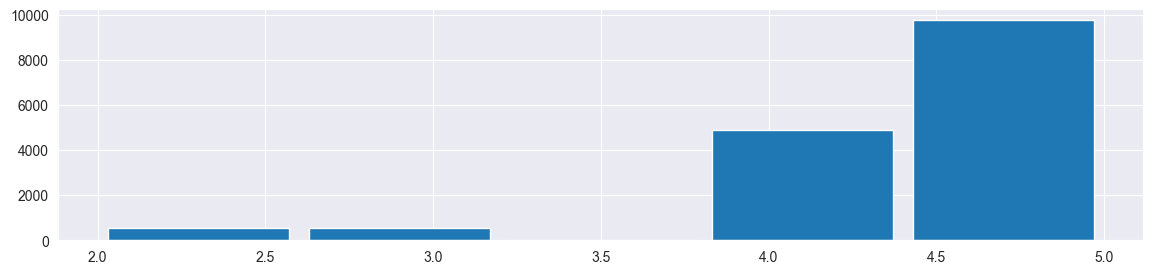

In [34]:
processed_df.doors_count.hist(bins=5, rwidth=0.9)

#### Количество мест

<Axes: >

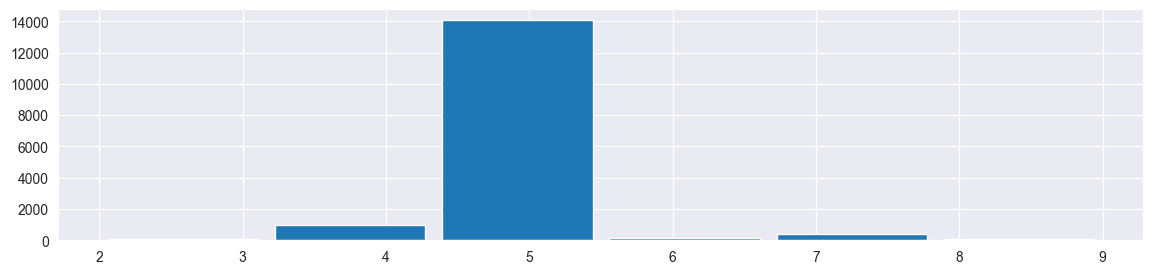

In [35]:
processed_df.seats_count.hist(bins=6, rwidth=0.9)

#### Длина

<Axes: >

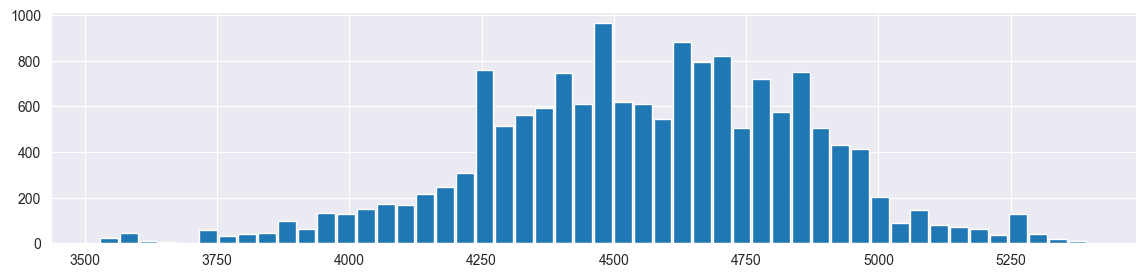

In [36]:
processed_df.length.hist(bins=50, rwidth=0.9)

#### Ширина

<Axes: >

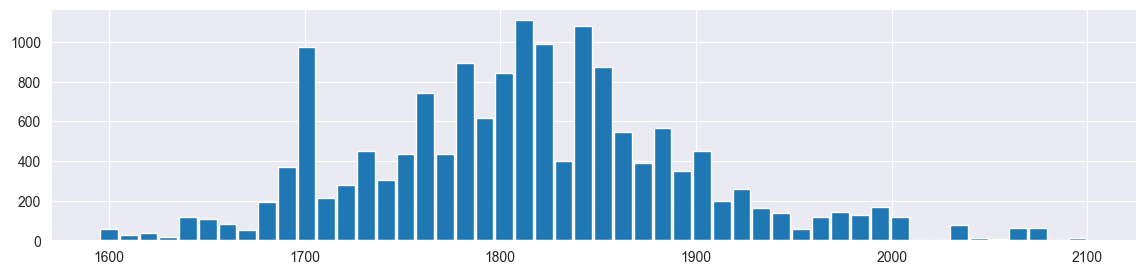

In [37]:
processed_df.width.hist(bins=50, rwidth=0.9)

#### Высота

<Axes: >

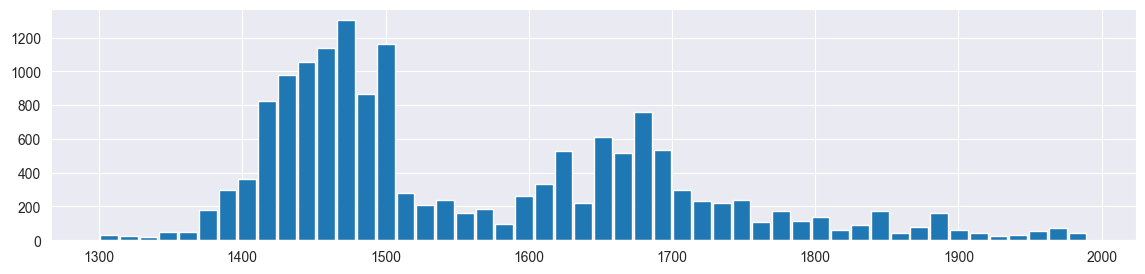

In [38]:
processed_df.height.hist(bins=50, rwidth=0.9)

#### Колёсная база

<Axes: >

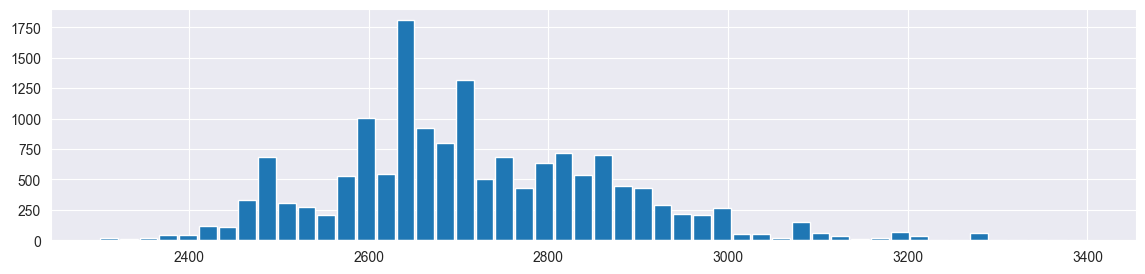

In [39]:
processed_df.wheelbase.hist(bins=50, rwidth=0.9)

#### Клиренс

<Axes: >

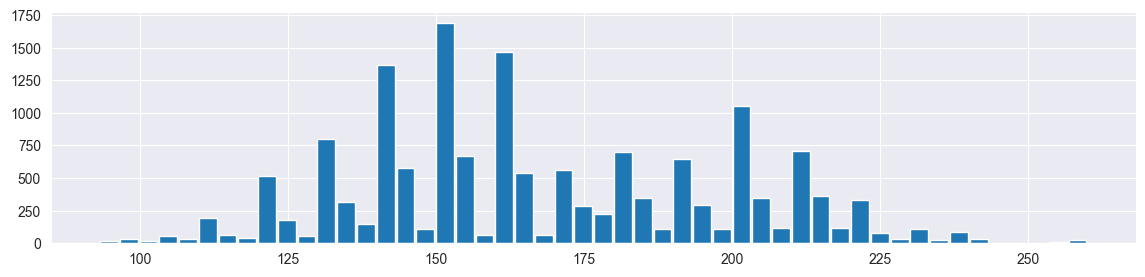

In [40]:
processed_df.clearance.hist(bins=50, rwidth=0.9)

#### Передняя колея

<Axes: >

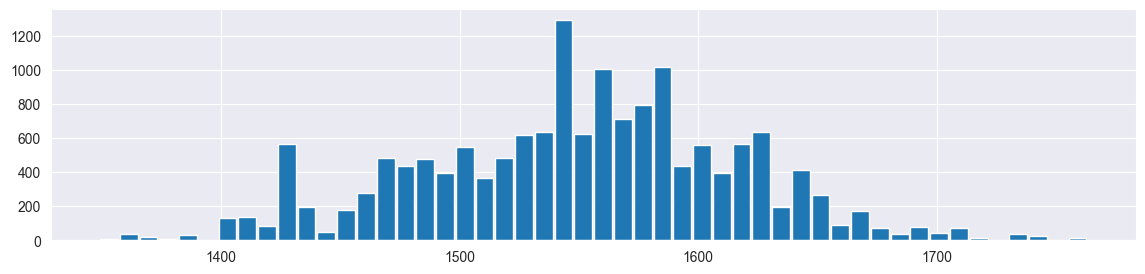

In [41]:
processed_df.front_track.hist(bins=50, rwidth=0.9)

#### Задняя колея

<Axes: >

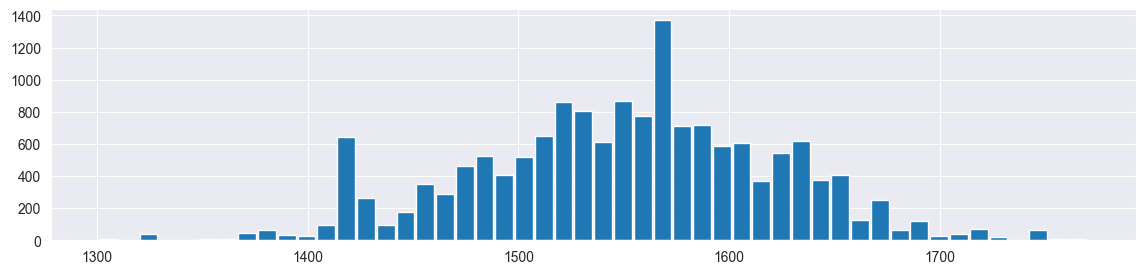

In [42]:
processed_df.rear_track.hist(bins=50, rwidth=0.9)

#### Максимальная скорость

<Axes: >

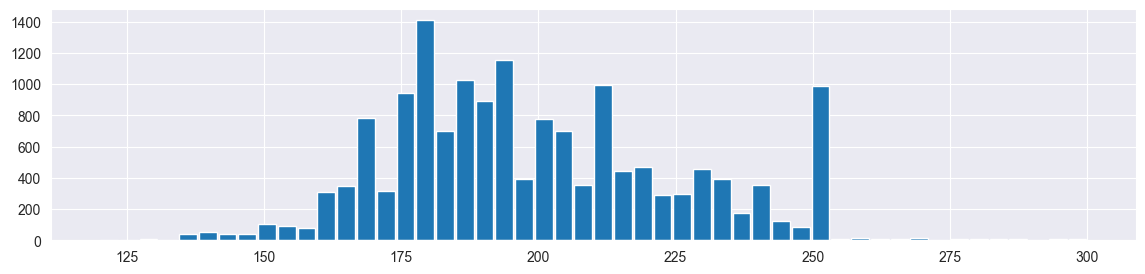

In [43]:
processed_df.max_speed.hist(bins=50, rwidth=0.9)

#### Разгон до 100

<Axes: >

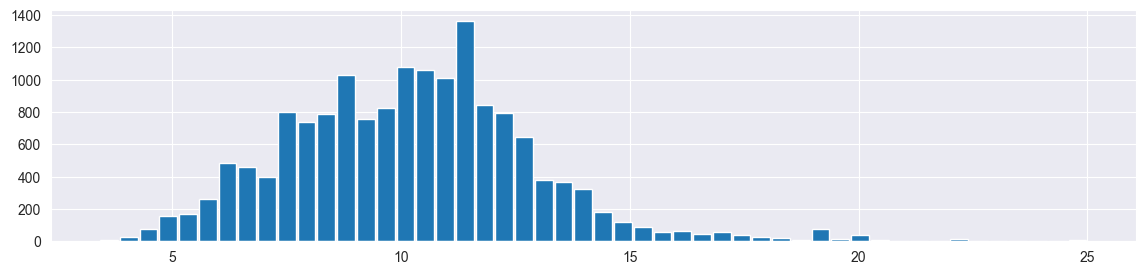

In [44]:
processed_df.zero_to_100.hist(bins=50, rwidth=0.9)

#### Смешанный расход топлива

<Axes: >

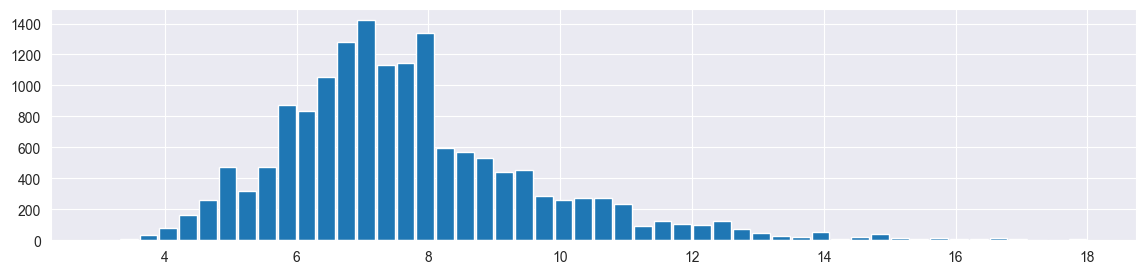

In [45]:
processed_df.fuel_consumption_mixed.hist(bins=50, rwidth=0.9)

#### Объём двигателя

<Axes: >

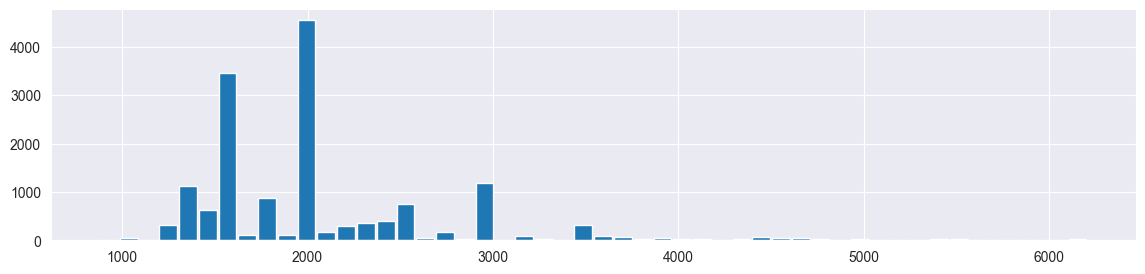

In [46]:
processed_df.engine_displacement.hist(bins=50, rwidth=0.9)

#### Мощность двигателя

<Axes: >

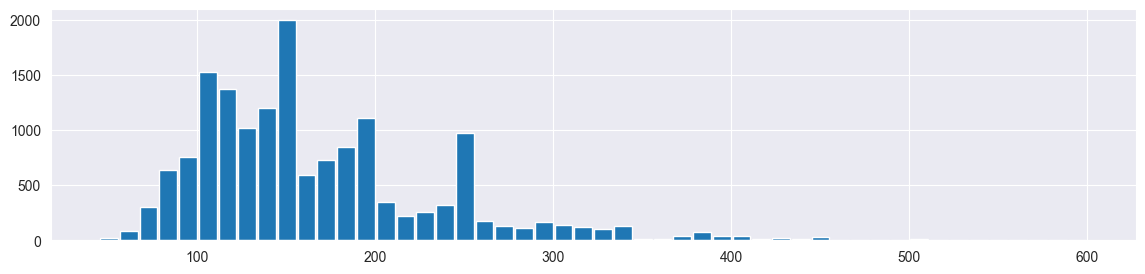

In [47]:
processed_df.engine_max_horsepower.hist(bins=50, rwidth=0.9)

#### Крутящий момент двигателя

<Axes: >

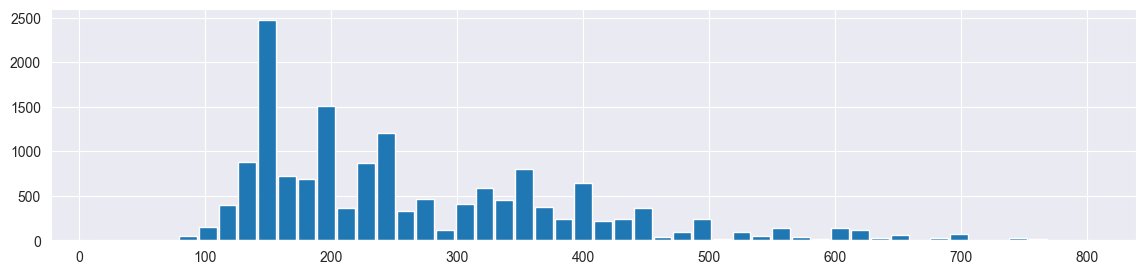

In [48]:
processed_df.engine_max_torque.hist(bins=50, rwidth=0.9)

#### Количество цилиндров в двигателе

<Axes: >

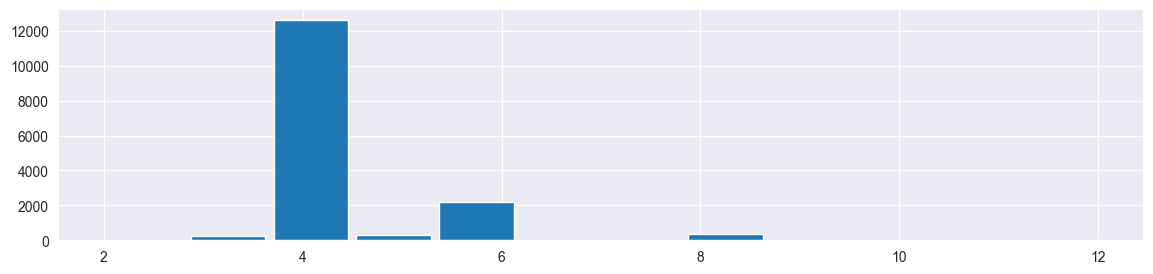

In [49]:
processed_df.engine_cylinders_count.hist(bins=12, rwidth=0.9)

#### Средняя цена

<Axes: >

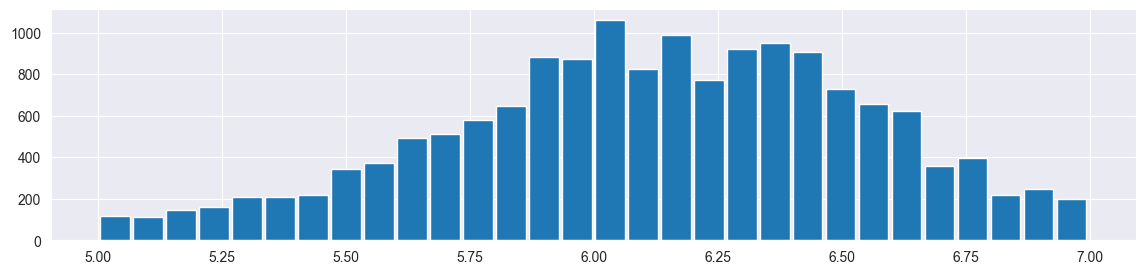

In [50]:
processed_df.price_avg.hist(bins=30, rwidth=0.9)

### Коррелограмма

In [51]:
mc.MoveToLast(processed_df, 'target')

doors_count  seats_count  length  width  height  wheelbase  clearance  \
70               5            5    4394   1781    1722       2619        200   
71               5            5    4394   1781    1722       2619        200   
74               5            5    4394   1781    1722       2619        200   
117              4            6    4782   1904    1940       3098        164   
118              4            6    4782   1904    1940       3098        164   
...            ...          ...     ...    ...     ...        ...        ...   
58263            4            5    4630   1760    1480       2700        150   
58264            4            5    4630   1760    1480       2700        150   
58266            4            5    4630   1760    1480       2700        150   
58267            4            5    4630   1760    1480       2700        150   
58268            4            5    4630   1760    1480       2700        150   

       front_track  rear_track  max_speed  ...  body_type_Родстер  \
70            1554        1550        190  ...              False   
71            1554        1550        171  ...              False   
74            1554        1550        188  ...              False   
117           1615        1630        155  ...              False   
118           1615        1630        155  ...              False   
...            ...         ...        ...  ...                ...   
58263         1505        1510        220  ...              False   
58264         1505        1510        185  ...              False   
58266         1505        1510        205  ...              False   
58267         1505        1510        195  ...              False   
58268         1505        1510        200  ...              False   

       body_type_Седан  body_type_Универсал  body_type_Фургон  \
70               False                False             False   
71               False                False             False   
74               False                False             False   
117              False                False             False   
118              False                False             False   
...                ...                  ...               ...   
58263             True                False             False   
58264             True                False             False   
58266             True                False             False   
58267             True                False             False   
58268             True                False             False   

       body_type_Хэтчбек  engine_type_ГБО  engine_type_бензиновый  \
70                 False            False                    True   
71                 False            False                    True   
74                 False            False                    True   
117                False            False                   False   
118                False            False                   False   
...                  ...              ...                     ...   
58263              False            False                    True   
58264              False            False                    True   
58266              False            False                    True   
58267              False            False                    True   
58268              False            False                    True   

       engine_type_гибридный  engine_type_дизельный  target  
70                     False                  False       2  
71                     False                  False       2  
74                     False                  False       2  
117                    False                   True       1  
118                    False                   True       1  
...                      ...                    ...     ...  
58263                  False                  False       1  
58264                  False                  False       1  
58266                  False                  Fal

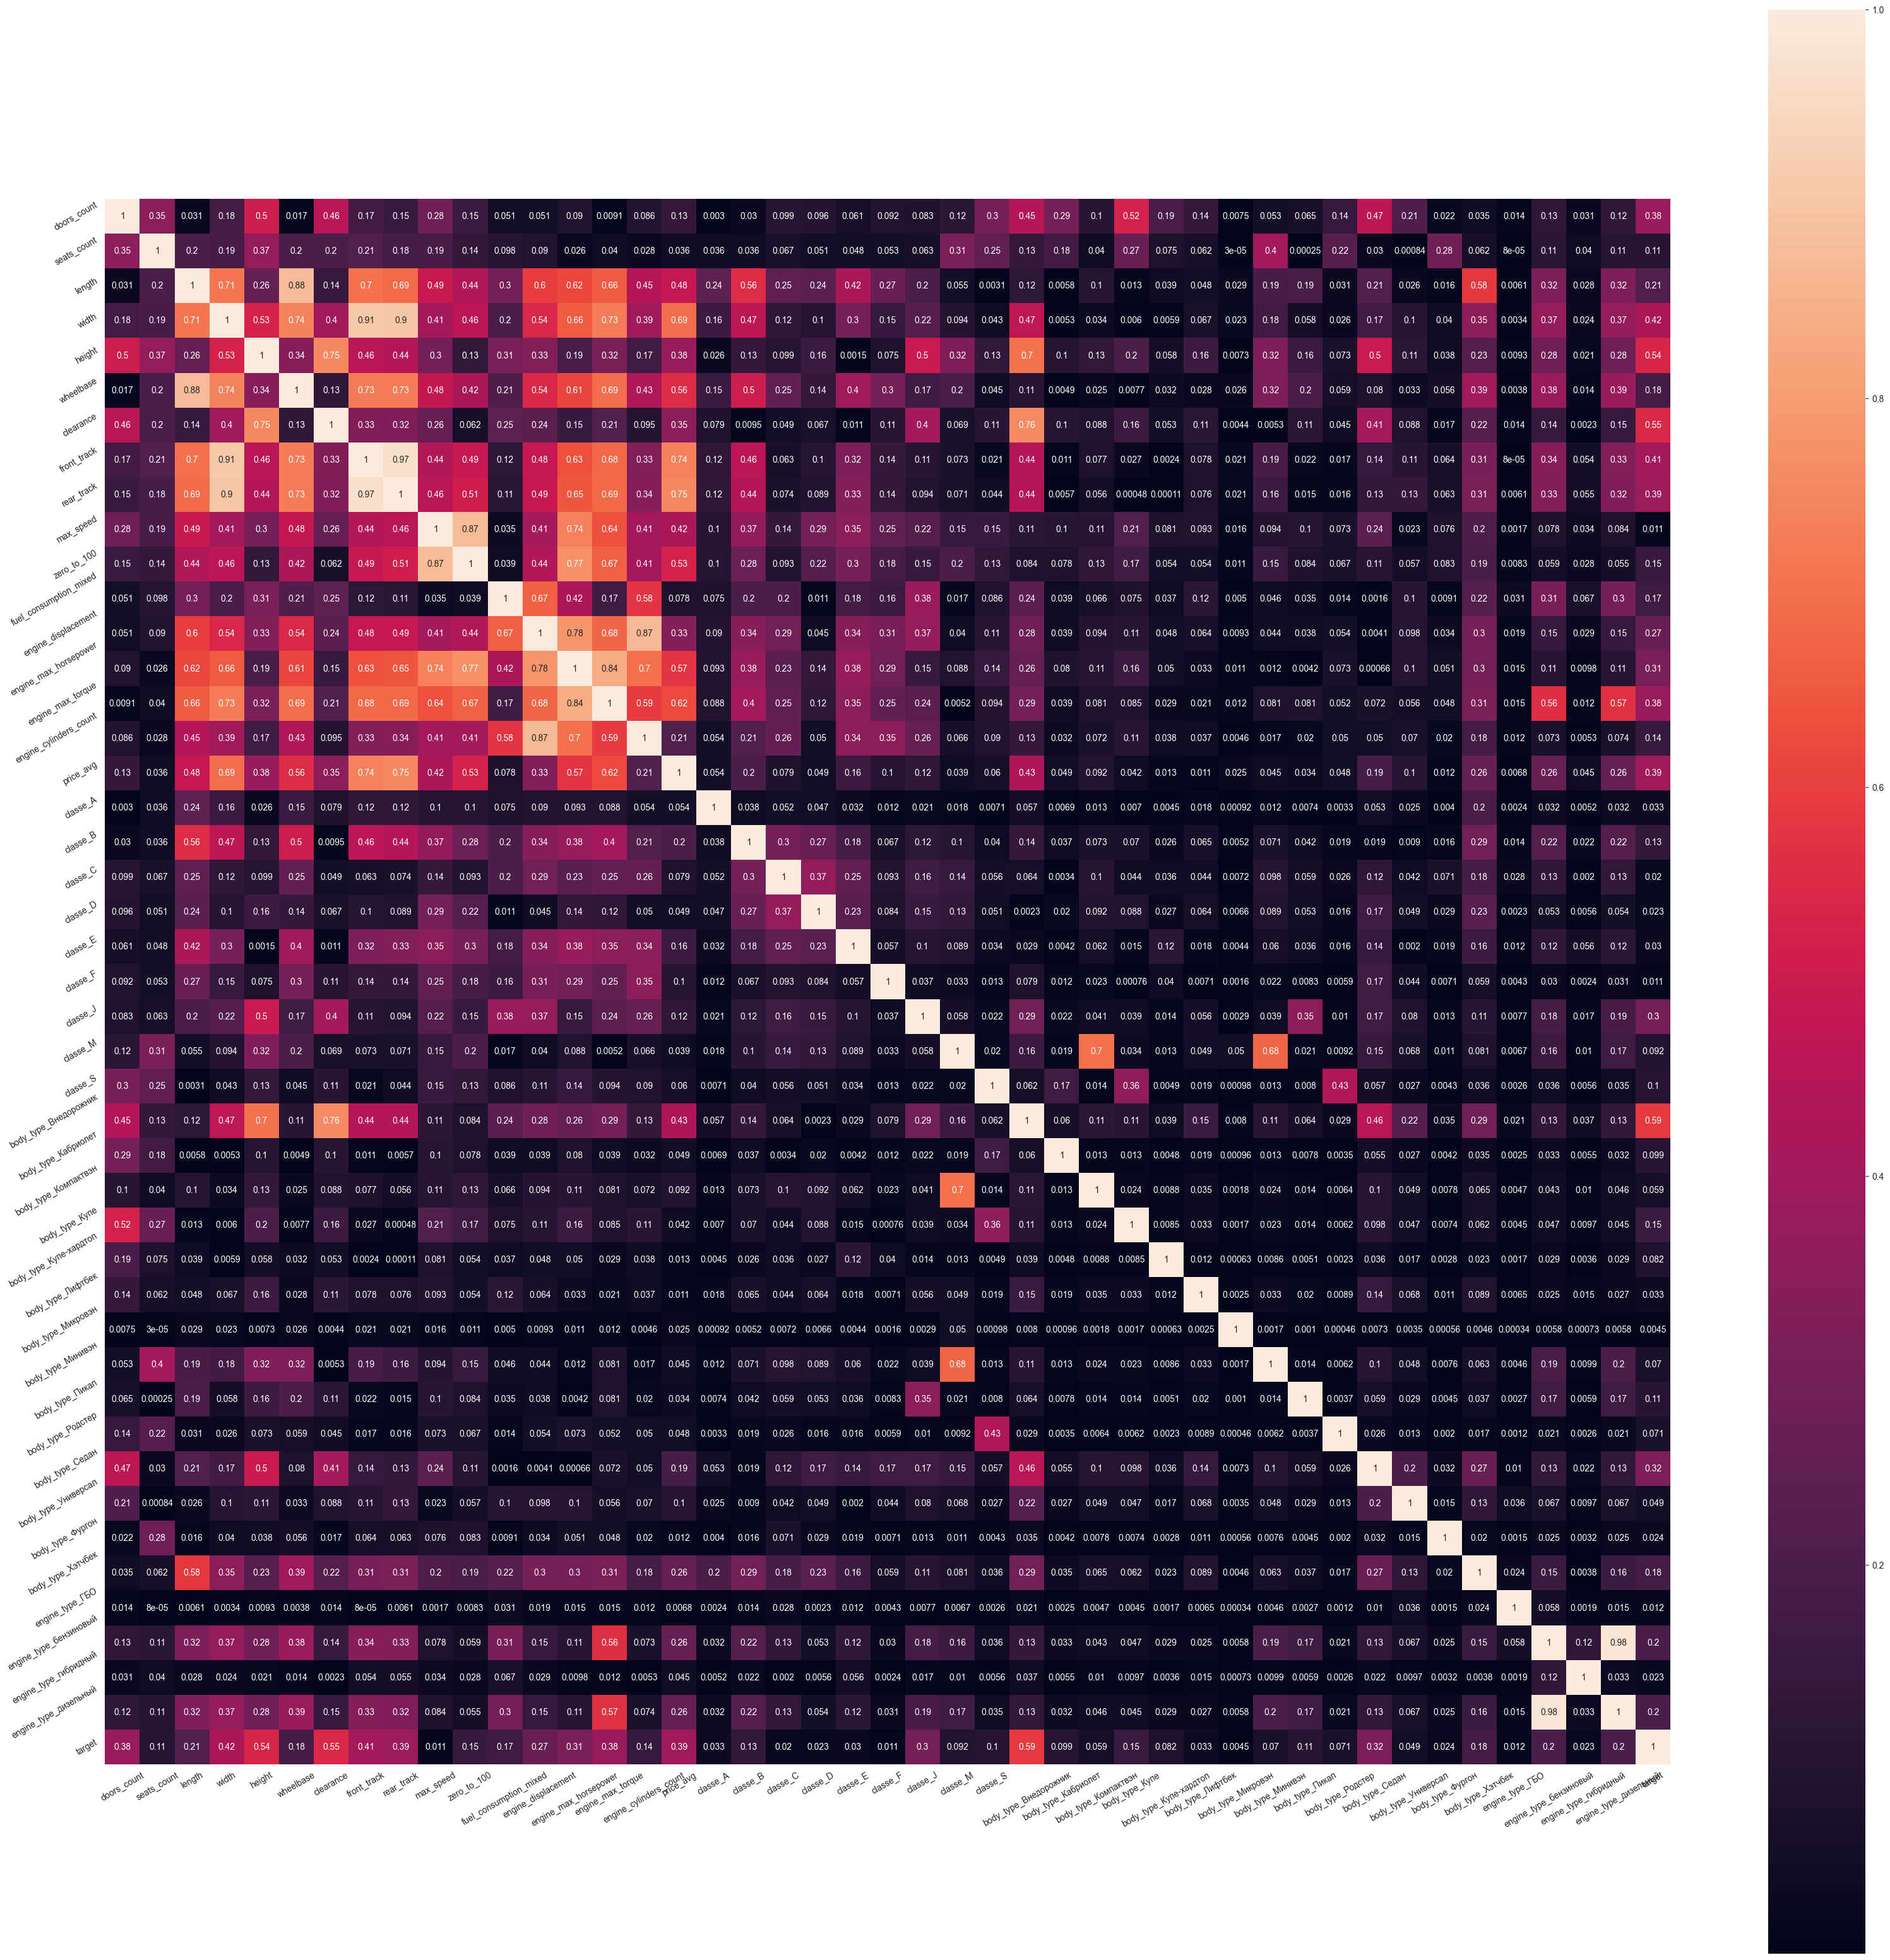

In [52]:
plt.figure(figsize=(40, 40))
sns.heatmap(processed_df.corr().abs(), square=True, linecolor='white', annot=True)
plt.yticks(rotation=30)
plt.xticks(rotation=30)
plt.show()

Штош, смотрим на последнюю строку и видим, что половину фич можно выкинуть к чертям.

Итак, имеет смысл оставить только:
doors_count, width, height, clearance, front_track, rear_track, engine_max_horsepower, engine_max_torque, price_avg, classe_J, body_type_Внедорожник, body_type_Седан

In [53]:
processed_df.columns

Index(['doors_count', 'seats_count', 'length', 'width', 'height', 'wheelbase',
       'clearance', 'front_track', 'rear_track', 'max_speed', 'zero_to_100',
       'fuel_consumption_mixed', 'engine_displacement',
       'engine_max_horsepower', 'engine_max_torque', 'engine_cylinders_count',
       'price_avg', 'classe_A', 'classe_B', 'classe_C', 'classe_D', 'classe_E',
       'classe_F', 'classe_J', 'classe_M', 'classe_S', 'body_type_Внедорожник',
       'body_type_Кабриолет', 'body_type_Компактвэн', 'body_type_Купе',
       'body_type_Купе-хардтоп', 'body_type_Лифтбек', 'body_type_Микровэн',
       'body_type_Минивэн', 'body_type_Пикап', 'body_type_Родстер',
       'body_type_Седан', 'body_type_Универсал', 'body_type_Фургон',
       'body_type_Хэтчбек', 'engine_type_ГБО', 'engine_type_бензиновый',
       'engine_type_гибридный', 'engine_type_дизельный', 'target'],
      dtype='object')

In [54]:
# processed_df = processed_df[["length", "width", "height", "wheelbase", "clearance", "front_track", "rear_track", "max_speed", "zero_to_100", "engine_displacement", "engine_max_horsepower", "engine_max_torque", "engine_cylinders_count", "drive_type_передний", "drive_type_полный", "engine_type_бензиновый", "engine_type_дизельный", "classe_B", "classe_C", "classe_E", "classe_F", "classe_J", "target"]]
# processed_df = processed_df[["length", "width", "height", "wheelbase", "front_track", "rear_track", "max_speed", "zero_to_100", "engine_displacement", "engine_max_horsepower", "engine_max_torque", "engine_cylinders_count", "drive_type_передний", "drive_type_полный", "target"]]
# processed_df = processed_df[
#     ["doors_count", "width", "height", "clearance", "front_track", "rear_track", "engine_max_horsepower",
#      "engine_max_torque", "price_avg", "classe_J", "body_type_Внедорожник", "body_type_Седан", "target"]]

In [55]:
# plt.figure(figsize=(20, 19))
# sns.heatmap(processed_df.corr().abs(), square=True, linecolor='white', annot=True)
# plt.yticks(rotation=30)
# plt.xticks(rotation=30)
# plt.show()

## Разбиение на train, valid, test

In [56]:
x = processed_df.drop('target', axis=1)
y = processed_df['target']
train_features, test_features, train_target, test_target = train_test_split(x, y, test_size=0.5, random_state=0)

print(train_features.shape)
print(train_target.shape)

print(test_features.shape)
print(test_target.shape)

(7863, 44)
(7863,)
(7864, 44)
(7864,)


## Выбор функции качества

По опыту прошлого семестра чувствую, что здесь с кайфом зайдёт f1 мера

In [57]:
from sklearn.metrics import f1_score, classification_report

In [58]:
def stat_visualize(predictions, test):
    predictions = pd.Series(predictions)
    fig, ax = plt.subplots()
    ax.hist(test, bins=3, fc=(0, 1, 0, 1.0))
    ax.hist(predictions, bins=3, fc=(0, 0, 1, 0.5))

In [59]:
def plot_f1_scores(models, labels, is_log=False, **kwargs):
    f1_scores_train = []
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Вычисление F1-меры для каждой модели
    for model in models:
        y_pred = model.predict(train_features.to_numpy(), **kwargs)
        f1 = f1_score(train_target, y_pred, average='weighted')
        f1_scores_train.append(f1)

    # Построение графика

    ax1.plot(labels, f1_scores_train, marker='o', linestyle='-', color='b')
    ax1.set_xlabel("Высота")
    ax1.set_ylabel('F1-мера')
    ax1.set_title('Train')
    ax1.set_xticks(labels)
    if is_log:
        ax1.set_xscale("log")
    ax1.grid(True)

    f1_scores_test = []
    # Вычисление F1-меры для каждой модели
    for model in models:
        y_pred = model.predict(test_features.to_numpy())
        f1 = f1_score(test_target, y_pred, average='weighted')
        f1_scores_test.append(f1)

    # Построение графика

    ax2.plot(labels, f1_scores_test, marker='o', linestyle='-', color='b')
    ax2.set_xlabel("Высота")
    ax2.set_ylabel('F1-мера')
    ax2.set_title('Test')
    ax2.set_xticks(labels)
    if is_log:
        ax2.set_xscale("log")
    ax2.grid(True)
    plt.show()


In [81]:
def visualize_descent(train_loss, test_loss, test_f1, title=""):
    fig, (ax1) = plt.subplots()
    ax1.set_title(title)
    ax1.set_ylim([0., 1.])
    x_ticks = np.arange(1, len(train_loss) + 1)
    ax1.plot(x_ticks, train_loss, label="Train Loss")
    ax1.plot(x_ticks, test_loss, label="Test Loss")
    ax1.plot(x_ticks, test_f1, label="Test F1")
    ax1.yaxis.tick_right()
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel("# of iter", fontsize=20)

# MLP

## Просто MLP

In [82]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, train_mode):
        super(MLP, self).__init__()
        layers = []
        self.train_mode = train_mode
        in_features = input_size
        
        for hidden_units in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_units))
            if self.train_mode:
                layers.append(nn.Dropout(p=0.2))
            layers.append(nn.Sigmoid())
            in_features = hidden_units
        
        layers.append(nn.Linear(in_features, output_size))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

In [83]:
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = train_features.shape[1]
hidden_layers_options = \
    [[128], 
     [128, 64], 
     [128, 64, 64], 
     [128, 128, 64, 64], 
     [128, 64, 64, 64],
     [128, 128, 128, 128],
     [64, 64, 64, 64],
     [128, 64, 32, 16],
     [128, 64, 32, 16],
     [128, 128, 64, 64, 64],
     ]
output_size = len(np.unique(train_target))
learning_rate = 0.001
num_epochs = 500
batch_size = 2000  # 7863


train_features_torch = torch.from_numpy(train_features.values.astype(np.float64)).float().to(device)
train_target_torch = torch.from_numpy(train_target.values.astype(np.int64)).long().to(device)
test_features_torch = torch.from_numpy(test_features.values.astype(np.float64)).float().to(device)
test_target_torch = torch.from_numpy(test_target.values.astype(np.int64)).long().to(device)

CUDA is available: True


Hidden layers: [128]
Epoch 1/500, Train Loss: 0.9485, Test Loss: 0.8745, Test F1 Score: 0.4600
Epoch 2/500, Train Loss: 0.8745, Test Loss: 0.8463, Test F1 Score: 0.4578
Epoch 3/500, Train Loss: 0.8514, Test Loss: 0.8216, Test F1 Score: 0.6499
Epoch 4/500, Train Loss: 0.8317, Test Loss: 0.7992, Test F1 Score: 0.6791
Epoch 5/500, Train Loss: 0.8176, Test Loss: 0.7786, Test F1 Score: 0.6818
Epoch 6/500, Train Loss: 0.8014, Test Loss: 0.7589, Test F1 Score: 0.6959
Epoch 7/500, Train Loss: 0.7796, Test Loss: 0.7400, Test F1 Score: 0.7006
Epoch 8/500, Train Loss: 0.7628, Test Loss: 0.7256, Test F1 Score: 0.7044
Epoch 9/500, Train Loss: 0.7502, Test Loss: 0.7110, Test F1 Score: 0.6949
Epoch 10/500, Train Loss: 0.7345, Test Loss: 0.6948, Test F1 Score: 0.7048
Epoch 11/500, Train Loss: 0.7230, Test Loss: 0.6868, Test F1 Score: 0.6978
Epoch 12/500, Train Loss: 0.7137, Test Loss: 0.6868, Test F1 Score: 0.7008
Epoch 13/500, Train Loss: 0.7062, Test Loss: 0.6709, Test F1 Score: 0.6952
Epoch 14/500,

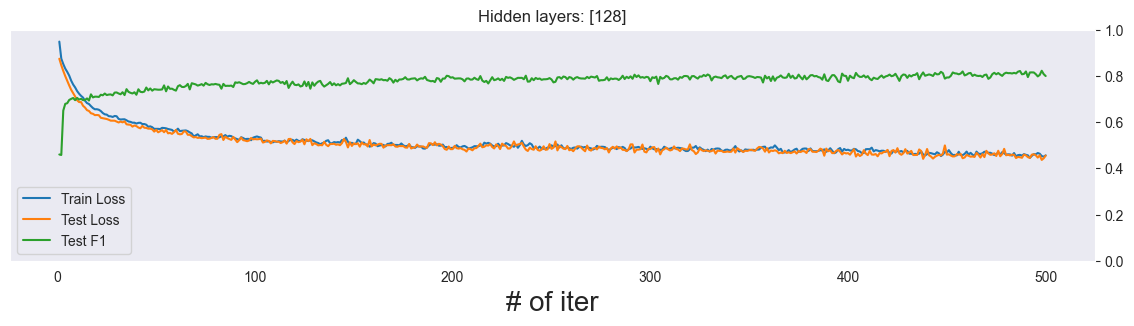

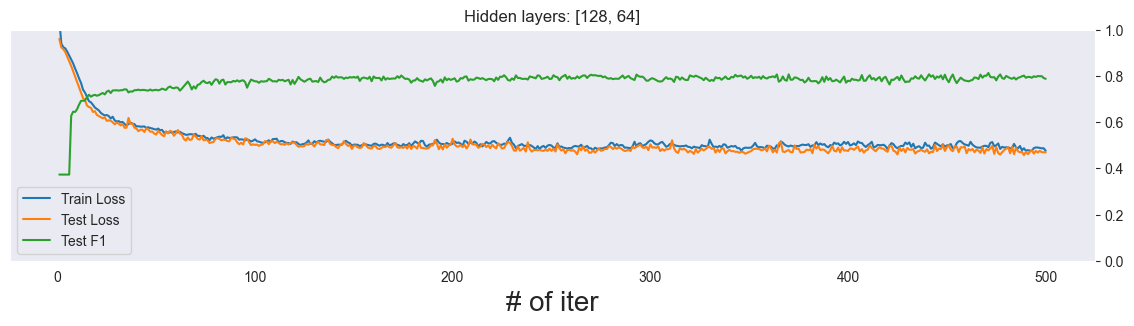

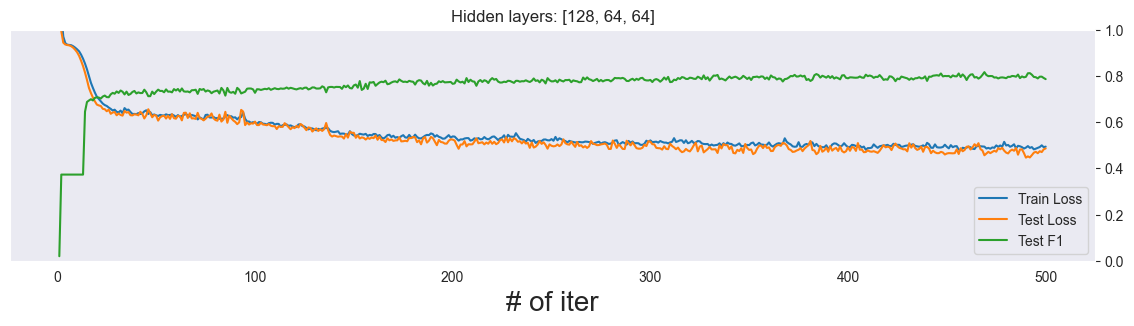

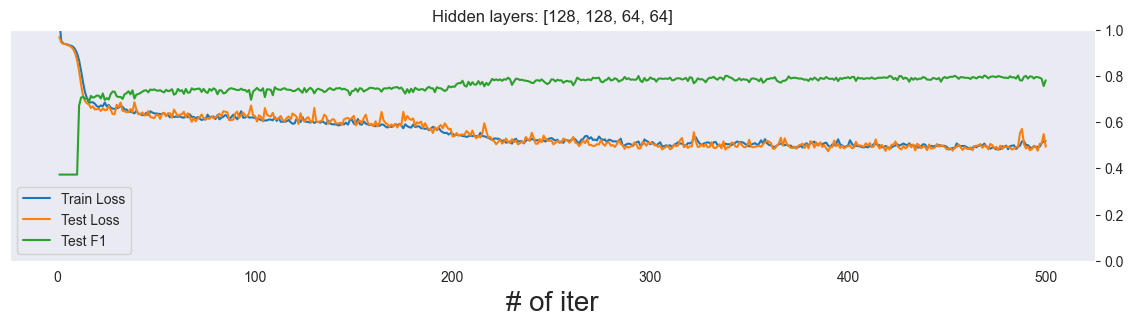

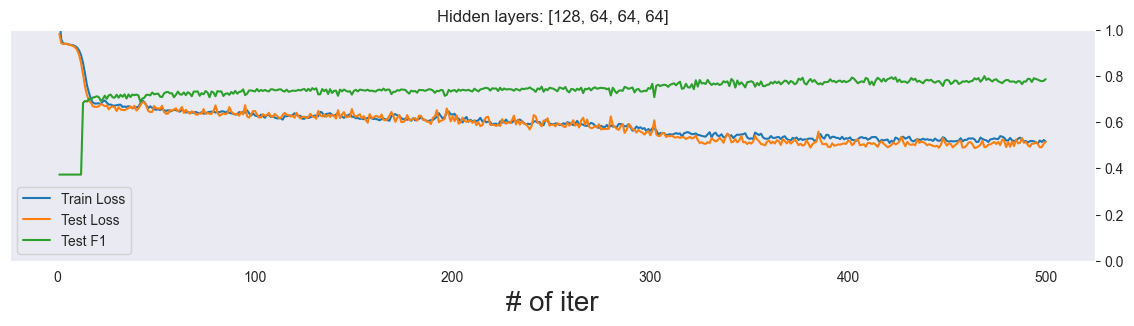

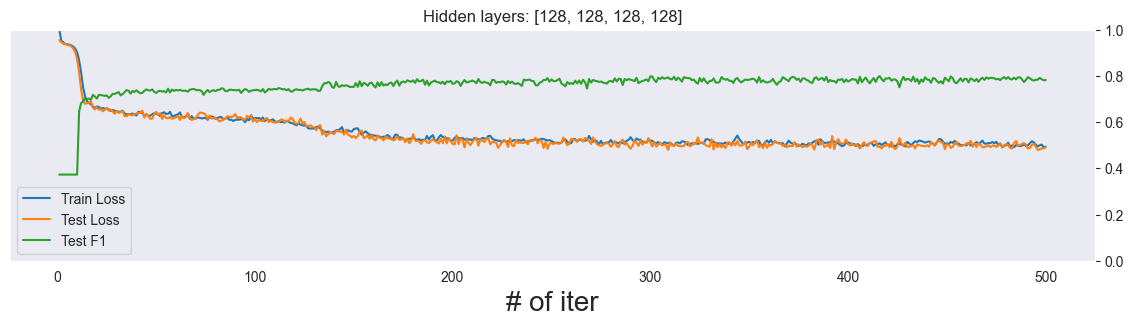

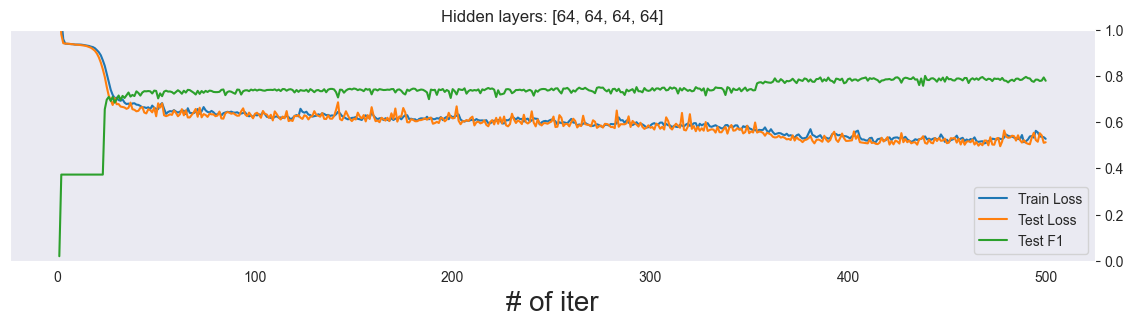

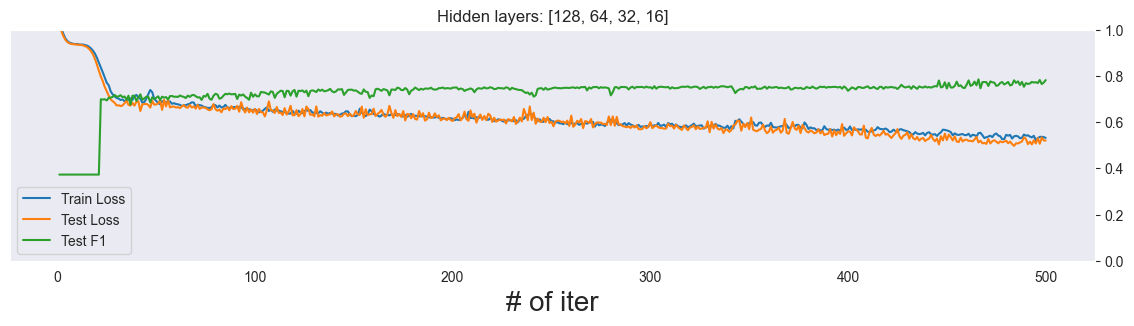

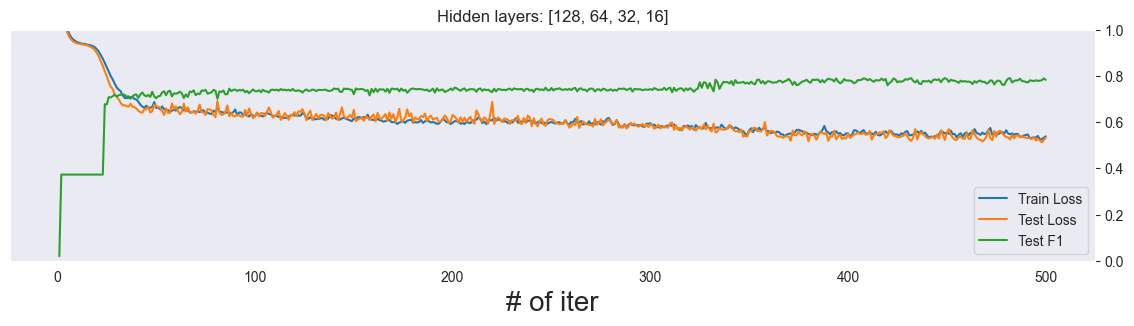

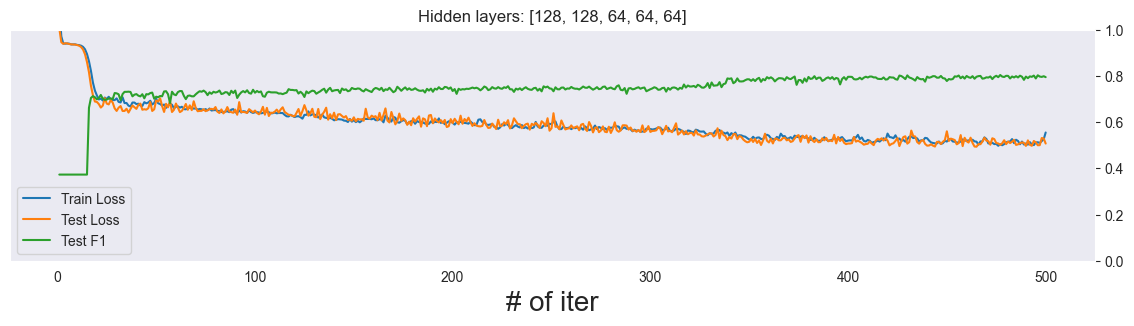

In [84]:
for hidden_layers in hidden_layers_options:
    train_dataset = TensorDataset(train_features_torch, train_target_torch)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    test_dataset = TensorDataset(test_features_torch, test_target_torch)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model = MLP(input_size=input_size, hidden_layers=hidden_layers, output_size=output_size, train_mode=True).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    print(f"Hidden layers: {hidden_layers}")
    train_loss_history = []
    test_loss_history = []
    test_f1_history = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for features, target in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        model.eval()
        test_loss = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for features, target in test_loader:
                outputs = model(features)
                loss = criterion(outputs, target)
                test_loss += loss.item()
                
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
        
        test_loss /= len(test_loader)
        test_f1 = f1_score(all_targets, all_preds, average='weighted')
        
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        test_f1_history.append(test_f1)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test F1 Score: {test_f1:.4f}")
    visualize_descent(train_loss_history, test_loss_history, test_f1_history, title=f"Hidden layers: {hidden_layers}")

### Зависимость от числа слоёв

In [85]:
def hidden_layers_gen(count):
    if count == 1:
        return [128]
    return [128 for _ in range(count // 2)] + [64 for _ in range(count - (count // 2))]

Hidden layers: [128]
Epoch 1/500, Train Loss: 0.9746, Test Loss: 0.8602, Test F1 Score: 0.4708
Epoch 2/500, Train Loss: 0.8591, Test Loss: 0.8190, Test F1 Score: 0.6255
Epoch 3/500, Train Loss: 0.8313, Test Loss: 0.7964, Test F1 Score: 0.6463
Epoch 4/500, Train Loss: 0.8074, Test Loss: 0.7666, Test F1 Score: 0.6642
Epoch 5/500, Train Loss: 0.7829, Test Loss: 0.7467, Test F1 Score: 0.6611
Epoch 6/500, Train Loss: 0.7644, Test Loss: 0.7305, Test F1 Score: 0.6730
Epoch 7/500, Train Loss: 0.7518, Test Loss: 0.7171, Test F1 Score: 0.6859
Epoch 8/500, Train Loss: 0.7392, Test Loss: 0.7092, Test F1 Score: 0.6777
Epoch 9/500, Train Loss: 0.7266, Test Loss: 0.7022, Test F1 Score: 0.6730
Epoch 10/500, Train Loss: 0.7186, Test Loss: 0.6861, Test F1 Score: 0.6856
Epoch 11/500, Train Loss: 0.7072, Test Loss: 0.6817, Test F1 Score: 0.6839
Epoch 12/500, Train Loss: 0.7029, Test Loss: 0.6838, Test F1 Score: 0.6796
Epoch 13/500, Train Loss: 0.6961, Test Loss: 0.6714, Test F1 Score: 0.6909
Epoch 14/500,

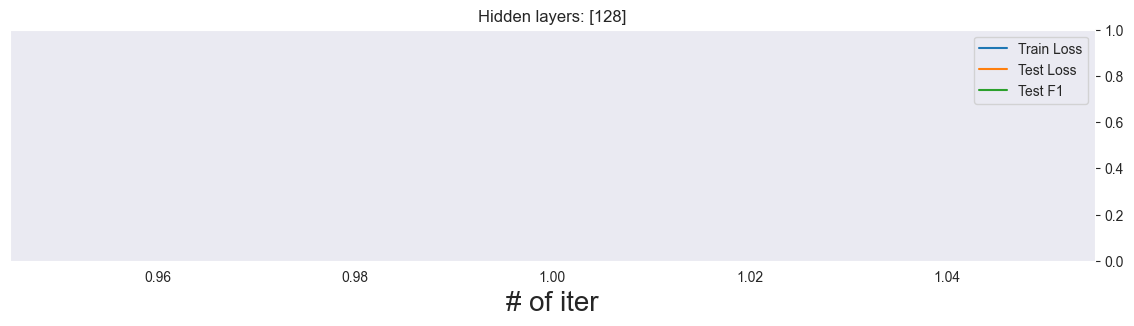

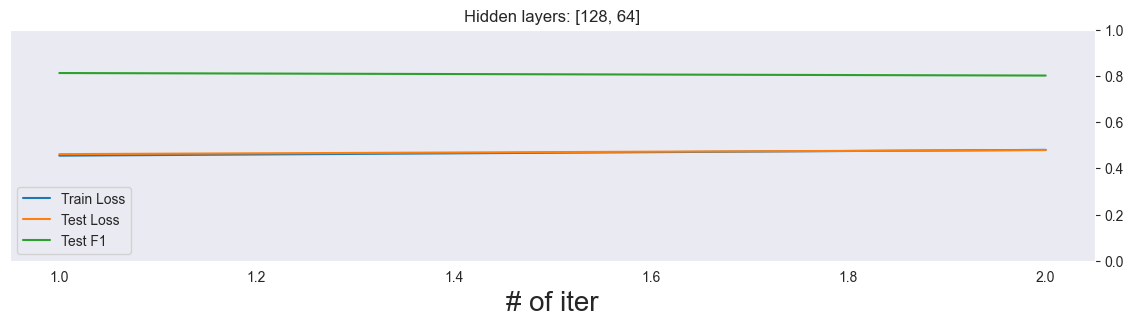

In [86]:
train_loss_history = []
test_loss_history = []
test_f1_history = []
for i in range(1, 30):
    hidden_layers = hidden_layers_gen(i)
    
    train_dataset = TensorDataset(train_features_torch, train_target_torch)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(test_features_torch, test_target_torch)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = MLP(input_size=input_size, hidden_layers=hidden_layers, output_size=output_size, train_mode=True).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"Hidden layers: {hidden_layers}")


    last_train_loss = None
    last_test_loss = None
    last_test_f1 = None
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for features, target in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        test_loss = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for features, target in test_loader:
                outputs = model(features)
                loss = criterion(outputs, target)
                test_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        test_loss /= len(test_loader)
        test_f1 = f1_score(all_targets, all_preds, average='weighted')

        last_train_loss = train_loss
        last_test_loss = test_loss
        last_test_f1 = test_f1
        print(
            f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test F1 Score: {test_f1:.4f}")
    train_loss_history.append(last_train_loss)
    test_loss_history.append(last_test_loss)
    test_f1_history.append(last_test_f1)
visualize_descent(train_loss_history, test_loss_history, test_f1_history, title=f"MLP")

## То же самое, но с Xavier

In [ ]:
class MLPXavier(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, train_mode):
        super(MLPXavier, self).__init__()
        layers = []
        self.train_mode = train_mode
        in_features = input_size
        
        for hidden_units in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_units))
            if self.train_mode:
                layers.append(nn.Dropout(p=0.2))
            layers.append(nn.Sigmoid())
            in_features = hidden_units
        
        layers.append(nn.Linear(in_features, output_size))
        self.network = nn.Sequential(*layers)
        self.init_weights()
    
    def init_weights(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
    
    def forward(self, x):
        return self.network(x)

In [ ]:
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = train_features.shape[1]
hidden_layers_options = \
    [[128], 
     [128, 64], 
     [128, 64, 64], 
     [128, 128, 64, 64], 
     [128, 64, 64, 64],
     [128, 128, 128, 128],
     [64, 64, 64, 64],
     [128, 64, 32, 16],
     [128, 64, 32, 16],
     [128, 128, 64, 64, 64],
     ]
output_size = len(np.unique(train_target))
learning_rate = 0.001
num_epochs = 500
batch_size = 2000  # 7863


train_features_torch = torch.from_numpy(train_features.values.astype(np.float64)).float().to(device)
train_target_torch = torch.from_numpy(train_target.values.astype(np.int64)).long().to(device)
test_features_torch = torch.from_numpy(test_features.values.astype(np.float64)).float().to(device)
test_target_torch = torch.from_numpy(test_target.values.astype(np.int64)).long().to(device)

In [ ]:
train_loss_history = []
test_loss_history = []
test_f1_history = []
for i in range(1, 30):
    hidden_layers = hidden_layers_gen(i)
    
    train_dataset = TensorDataset(train_features_torch, train_target_torch)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(test_features_torch, test_target_torch)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = MLPXavier(input_size=input_size, hidden_layers=hidden_layers, output_size=output_size, train_mode=True).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"Hidden layers: {hidden_layers}")


    last_train_loss = None
    last_test_loss = None
    last_test_f1 = None
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for features, target in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        test_loss = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for features, target in test_loader:
                outputs = model(features)
                loss = criterion(outputs, target)
                test_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        test_loss /= len(test_loader)
        test_f1 = f1_score(all_targets, all_preds, average='weighted')

        last_train_loss = train_loss
        last_test_loss = test_loss
        last_test_f1 = test_f1
        print(
            f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test F1 Score: {test_f1:.4f}")
    train_loss_history.append(last_train_loss)
    test_loss_history.append(last_test_loss)
    test_f1_history.append(last_test_f1)
visualize_descent(train_loss_history, test_loss_history, test_f1_history, title=f"Xavier")

## То же самое, но с пакетной нормализацией

In [ ]:
class MLPXavierBatchNorm(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, train_mode):
        super(MLPXavierBatchNorm, self).__init__()
        layers = []
        self.train_mode = train_mode
        in_features = input_size
        
        for hidden_units in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_units))
            if self.train_mode:
                layers.append(nn.Dropout(p=0.2))
            layers.append(nn.BatchNorm1d(hidden_units, momentum=0.9))
            layers.append(nn.Sigmoid())
            in_features = hidden_units
        
        layers.append(nn.Linear(in_features, output_size))
        self.network = nn.Sequential(*layers)
        self.init_weights()
    
    def init_weights(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
    
    def forward(self, x):
        return self.network(x)

In [ ]:
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = train_features.shape[1]
hidden_layers_options = \
    [[128], 
     [128, 64], 
     [128, 64, 64], 
     [128, 128, 64, 64], 
     [128, 64, 64, 64],
     [128, 128, 128, 128],
     [64, 64, 64, 64],
     [128, 64, 32, 16],
     [128, 64, 32, 16],
     [128, 128, 64, 64, 64],
     ]
output_size = len(np.unique(train_target))
learning_rate = 0.001
num_epochs = 500
batch_size = 2000  # 7863


train_features_torch = torch.from_numpy(train_features.values.astype(np.float64)).float().to(device)
train_target_torch = torch.from_numpy(train_target.values.astype(np.int64)).long().to(device)
test_features_torch = torch.from_numpy(test_features.values.astype(np.float64)).float().to(device)
test_target_torch = torch.from_numpy(test_target.values.astype(np.int64)).long().to(device)

In [ ]:
train_loss_history = []
test_loss_history = []
test_f1_history = []
for i in range(1, 30):
    hidden_layers = hidden_layers_gen(i)
    
    train_dataset = TensorDataset(train_features_torch, train_target_torch)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(test_features_torch, test_target_torch)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = MLPXavierBatchNorm(input_size=input_size, hidden_layers=hidden_layers, output_size=output_size, train_mode=True).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"Hidden layers: {hidden_layers}")


    last_train_loss = None
    last_test_loss = None
    last_test_f1 = None
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for features, target in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        test_loss = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for features, target in test_loader:
                outputs = model(features)
                loss = criterion(outputs, target)
                test_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        test_loss /= len(test_loader)
        test_f1 = f1_score(all_targets, all_preds, average='weighted')

        last_train_loss = train_loss
        last_test_loss = test_loss
        last_test_f1 = test_f1
        print(
            f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test F1 Score: {test_f1:.4f}")
    train_loss_history.append(last_train_loss)
    test_loss_history.append(last_test_loss)
    test_f1_history.append(last_test_f1)
visualize_descent(train_loss_history, test_loss_history, test_f1_history, title=f"Xavier + BatchNorm")

# ResNet

## Просто ResNet

![](data/screenshot1.png)

In [91]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, input_size, hidden_layers_size, output_size, num_layers):
        super(ResNet, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_layers_size)
        self.relu = nn.ReLU(inplace=True)
        layers = []
        for _ in range(num_layers):
            layers.append(ResidualBlock(hidden_layers_size))
        self.layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(hidden_layers_size, output_size)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.layers(x)
        x = self.output_layer(x)
        return x


In [92]:
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = train_features.shape[1]
hidden_layers_size = 64
output_size = len(np.unique(train_target))
learning_rate = 0.001
num_epochs = 500
batch_size = 2000  # 7863


train_features_torch = torch.from_numpy(train_features.values.astype(np.float64)).float().to(device)
train_target_torch = torch.from_numpy(train_target.values.astype(np.int64)).long().to(device)
test_features_torch = torch.from_numpy(test_features.values.astype(np.float64)).float().to(device)
test_target_torch = torch.from_numpy(test_target.values.astype(np.int64)).long().to(device)

CUDA is available: True


Hidden layers: 1
Epoch 1/500, Train Loss: 94.8247, Test Loss: 30.7337, Test F1 Score: 0.1943
Epoch 2/500, Train Loss: 47.5056, Test Loss: 37.5833, Test F1 Score: 0.1938
Epoch 3/500, Train Loss: 27.5933, Test Loss: 34.5728, Test F1 Score: 0.4128
Epoch 4/500, Train Loss: 27.4518, Test Loss: 21.1842, Test F1 Score: 0.1313
Epoch 5/500, Train Loss: 17.1107, Test Loss: 14.1929, Test F1 Score: 0.3804
Epoch 6/500, Train Loss: 16.0455, Test Loss: 11.3312, Test F1 Score: 0.3629
Epoch 7/500, Train Loss: 10.5959, Test Loss: 8.8199, Test F1 Score: 0.4671
Epoch 8/500, Train Loss: 7.7162, Test Loss: 6.9421, Test F1 Score: 0.3270
Epoch 9/500, Train Loss: 5.7796, Test Loss: 6.2667, Test F1 Score: 0.5309
Epoch 10/500, Train Loss: 5.1287, Test Loss: 4.4853, Test F1 Score: 0.5611
Epoch 11/500, Train Loss: 4.2926, Test Loss: 3.7835, Test F1 Score: 0.6419
Epoch 12/500, Train Loss: 3.8803, Test Loss: 3.2295, Test F1 Score: 0.6493
Epoch 13/500, Train Loss: 3.0173, Test Loss: 2.8951, Test F1 Score: 0.6611
Epoc

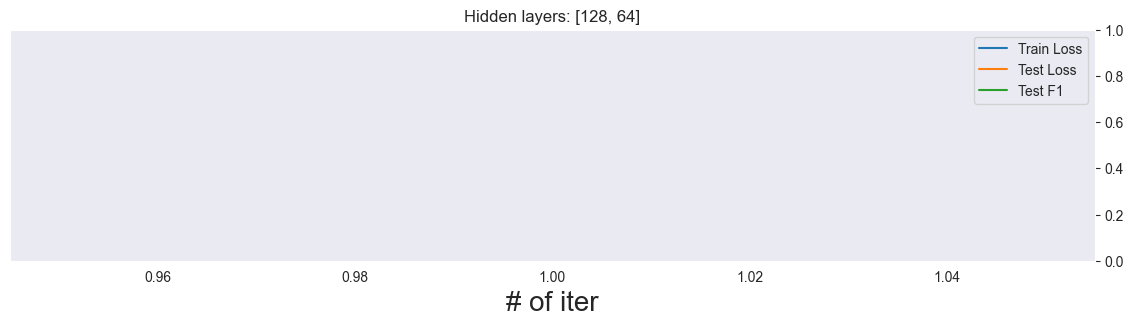

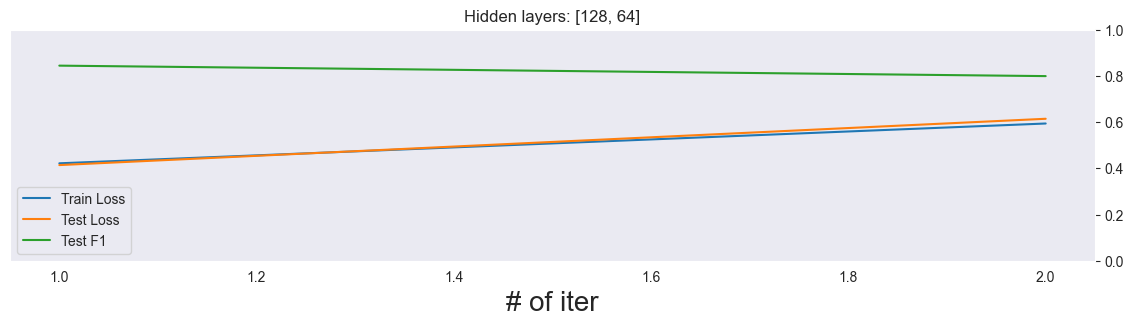

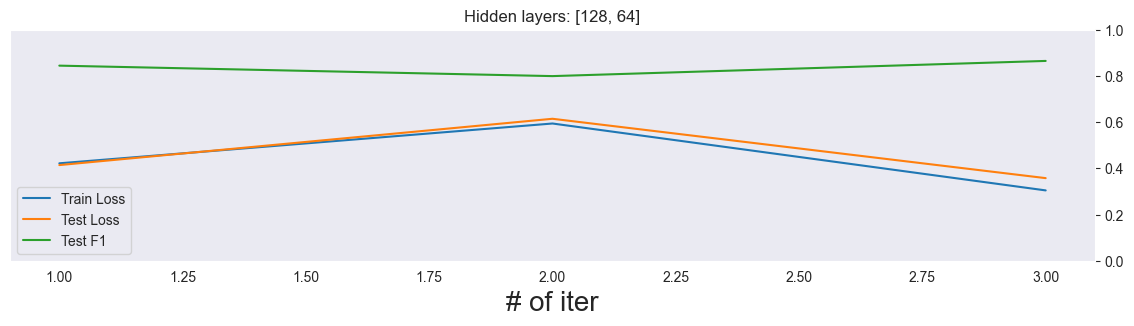

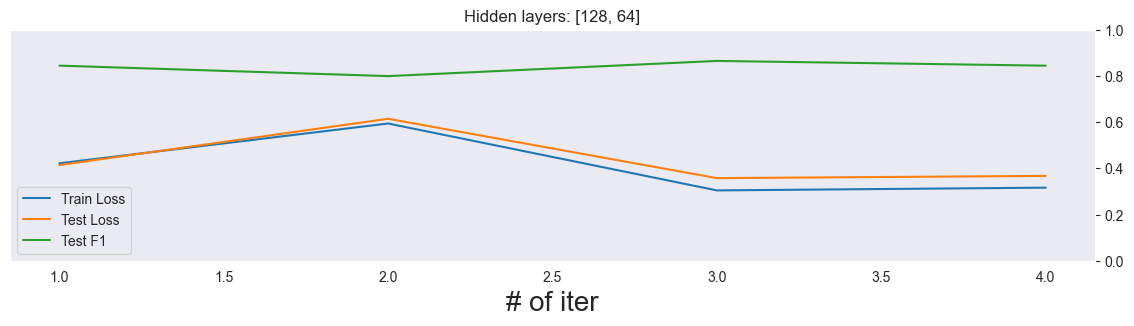

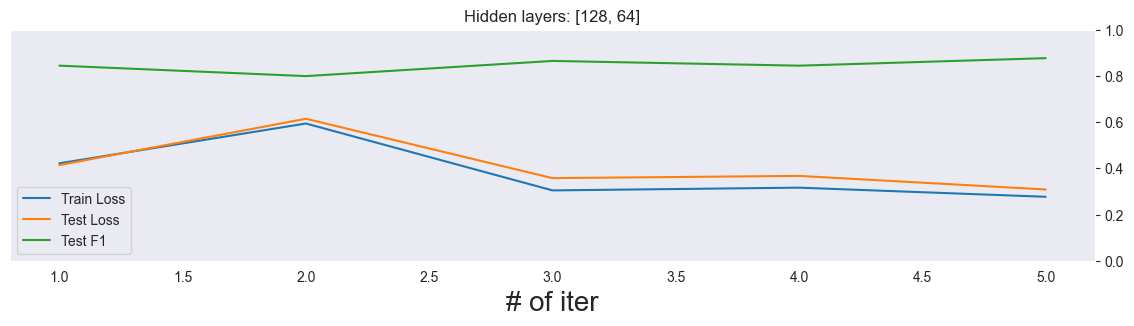

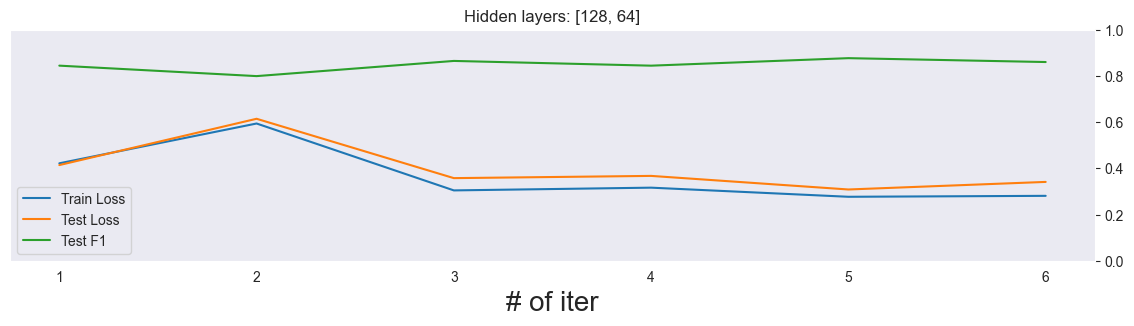

In [96]:
train_loss_history = []
test_loss_history = []
test_f1_history = []
for i in range(1, 30):
    train_dataset = TensorDataset(train_features_torch, train_target_torch)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(test_features_torch, test_target_torch)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = ResNet(input_size=input_size, hidden_layers_size=64, num_layers=i, output_size=output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"Hidden layers: {i}")


    last_train_loss = None
    last_test_loss = None
    last_test_f1 = None
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for features, target in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        test_loss = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for features, target in test_loader:
                outputs = model(features)
                loss = criterion(outputs, target)
                test_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        test_loss /= len(test_loader)
        test_f1 = f1_score(all_targets, all_preds, average='weighted')

        last_train_loss = train_loss
        last_test_loss = test_loss
        last_test_f1 = test_f1
        print(
            f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test F1 Score: {test_f1:.4f}")
    train_loss_history.append(last_train_loss)
    test_loss_history.append(last_test_loss)
    test_f1_history.append(last_test_f1)
visualize_descent(train_loss_history, test_loss_history, test_f1_history, title=f"ResNet")

## То же самое, но с Xavier

In [98]:
class ResidualBlockXavier(nn.Module):
    def __init__(self, input_dim):
        super(ResidualBlockXavier, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(input_dim, input_dim)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out += residual
        out = self.relu(out)
        return out

class ResNetXavier(nn.Module):
    def __init__(self, input_size, hidden_layers_size, output_size, num_layers):
        super(ResNetXavier, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_layers_size)
        self.relu = nn.ReLU(inplace=True)
        layers = []
        for _ in range(num_layers):
            layers.append(ResidualBlockXavier(hidden_layers_size))
        self.layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(hidden_layers_size, output_size)
    
        nn.init.xavier_uniform_(self.input_layer.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.layers(x)
        x = self.output_layer(x)
        return x


In [99]:
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = train_features.shape[1]
hidden_layers_size = 64
output_size = len(np.unique(train_target))
learning_rate = 0.001
num_epochs = 500
batch_size = 2000  # 7863


train_features_torch = torch.from_numpy(train_features.values.astype(np.float64)).float().to(device)
train_target_torch = torch.from_numpy(train_target.values.astype(np.int64)).long().to(device)
test_features_torch = torch.from_numpy(test_features.values.astype(np.float64)).float().to(device)
test_target_torch = torch.from_numpy(test_target.values.astype(np.int64)).long().to(device)

CUDA is available: True


Hidden layers: 1
Epoch 1/500, Train Loss: 272.6569, Test Loss: 199.6732, Test F1 Score: 0.2447
Epoch 2/500, Train Loss: 175.0370, Test Loss: 137.2854, Test F1 Score: 0.3737
Epoch 3/500, Train Loss: 103.3803, Test Loss: 63.2910, Test F1 Score: 0.2790
Epoch 4/500, Train Loss: 62.6145, Test Loss: 59.7071, Test F1 Score: 0.3782
Epoch 5/500, Train Loss: 46.1553, Test Loss: 47.8295, Test F1 Score: 0.3647
Epoch 6/500, Train Loss: 36.5752, Test Loss: 33.2164, Test F1 Score: 0.5160
Epoch 7/500, Train Loss: 28.5755, Test Loss: 22.3711, Test F1 Score: 0.5737
Epoch 8/500, Train Loss: 23.3592, Test Loss: 23.1094, Test F1 Score: 0.6507
Epoch 9/500, Train Loss: 21.1558, Test Loss: 18.6244, Test F1 Score: 0.6112
Epoch 10/500, Train Loss: 18.6624, Test Loss: 16.4435, Test F1 Score: 0.6562
Epoch 11/500, Train Loss: 16.9822, Test Loss: 15.7217, Test F1 Score: 0.6730
Epoch 12/500, Train Loss: 15.4776, Test Loss: 15.4492, Test F1 Score: 0.6449
Epoch 13/500, Train Loss: 14.5654, Test Loss: 14.3246, Test F1 

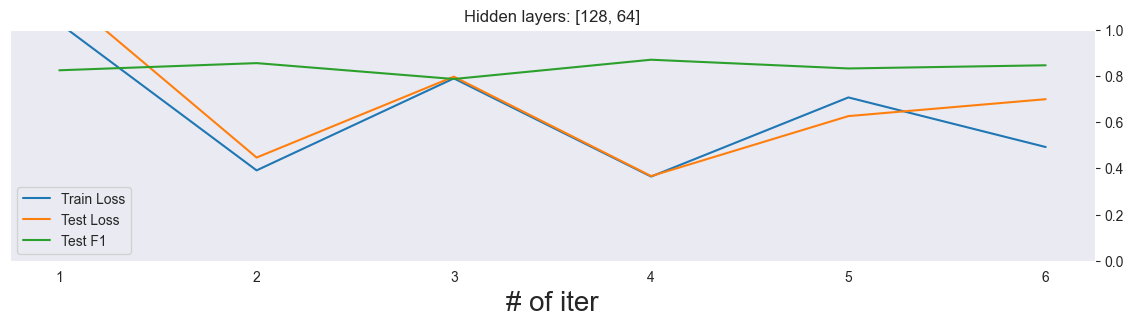

In [100]:
train_loss_history = []
test_loss_history = []
test_f1_history = []
for i in range(1, 30):
    train_dataset = TensorDataset(train_features_torch, train_target_torch)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(test_features_torch, test_target_torch)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = ResNetXavier(input_size=input_size, hidden_layers_size=64, num_layers=i, output_size=output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"Hidden layers: {i}")


    last_train_loss = None
    last_test_loss = None
    last_test_f1 = None
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for features, target in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        test_loss = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for features, target in test_loader:
                outputs = model(features)
                loss = criterion(outputs, target)
                test_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        test_loss /= len(test_loader)
        test_f1 = f1_score(all_targets, all_preds, average='weighted')

        last_train_loss = train_loss
        last_test_loss = test_loss
        last_test_f1 = test_f1
        print(
            f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test F1 Score: {test_f1:.4f}")
    train_loss_history.append(last_train_loss)
    test_loss_history.append(last_test_loss)
    test_f1_history.append(last_test_f1)
visualize_descent(train_loss_history, test_loss_history, test_f1_history, title="Xavier")

## То же самое, но с пакетной нормализацией

In [104]:
class ResidualBlockXavierBatchNorm(nn.Module):
    def __init__(self, input_dim):
        super(ResidualBlockXavierBatchNorm, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.bn1 = nn.BatchNorm1d(input_dim, momentum=0.9)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(input_dim, input_dim)
        self.bn2 = nn.BatchNorm1d(input_dim, momentum=0.9)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class ResNetXavierBatchNorm(nn.Module):
    def __init__(self, input_size, hidden_layers_size, output_size, num_layers):
        super(ResNetXavierBatchNorm, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_layers_size)
        self.bn_input = nn.BatchNorm1d(hidden_layers_size, momentum=0.9)
        self.relu = nn.ReLU(inplace=True)
        layers = []
        for _ in range(num_layers):
            layers.append(ResidualBlockXavierBatchNorm(hidden_layers_size))
        self.layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(hidden_layers_size, output_size)
    
        nn.init.xavier_uniform_(self.input_layer.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.bn_input(x)
        x = self.relu(x)
        x = self.layers(x)
        x = self.output_layer(x)
        return x

In [105]:
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = train_features.shape[1]
hidden_layers_size = 64
output_size = len(np.unique(train_target))
learning_rate = 0.001
num_epochs = 500
batch_size = 2000  # 7863


train_features_torch = torch.from_numpy(train_features.values.astype(np.float64)).float().to(device)
train_target_torch = torch.from_numpy(train_target.values.astype(np.int64)).long().to(device)
test_features_torch = torch.from_numpy(test_features.values.astype(np.float64)).float().to(device)
test_target_torch = torch.from_numpy(test_target.values.astype(np.int64)).long().to(device)

CUDA is available: True


Hidden layers: 1
Epoch 1/500, Train Loss: 1.4613, Test Loss: 1.3354, Test F1 Score: 0.3285
Epoch 2/500, Train Loss: 0.8739, Test Loss: 0.8184, Test F1 Score: 0.6859
Epoch 3/500, Train Loss: 0.6551, Test Loss: 0.6376, Test F1 Score: 0.7707
Epoch 4/500, Train Loss: 0.5710, Test Loss: 0.5624, Test F1 Score: 0.7818
Epoch 5/500, Train Loss: 0.5235, Test Loss: 0.5167, Test F1 Score: 0.7855
Epoch 6/500, Train Loss: 0.4884, Test Loss: 0.4897, Test F1 Score: 0.7906
Epoch 7/500, Train Loss: 0.4619, Test Loss: 0.4704, Test F1 Score: 0.7991
Epoch 8/500, Train Loss: 0.4414, Test Loss: 0.4526, Test F1 Score: 0.8077
Epoch 9/500, Train Loss: 0.4259, Test Loss: 0.4401, Test F1 Score: 0.8139
Epoch 10/500, Train Loss: 0.4144, Test Loss: 0.4297, Test F1 Score: 0.8170
Epoch 11/500, Train Loss: 0.4019, Test Loss: 0.4192, Test F1 Score: 0.8248
Epoch 12/500, Train Loss: 0.3896, Test Loss: 0.4116, Test F1 Score: 0.8228
Epoch 13/500, Train Loss: 0.3797, Test Loss: 0.4030, Test F1 Score: 0.8271
Epoch 14/500, Tra

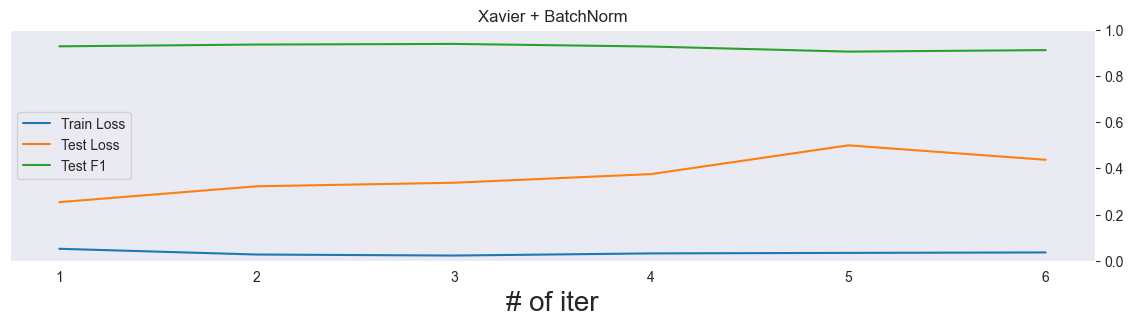

In [106]:
train_loss_history = []
test_loss_history = []
test_f1_history = []
for i in range(1, 30):
    train_dataset = TensorDataset(train_features_torch, train_target_torch)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(test_features_torch, test_target_torch)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = ResNetXavierBatchNorm(input_size=input_size, hidden_layers_size=64, num_layers=i, output_size=output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"Hidden layers: {i}")


    last_train_loss = None
    last_test_loss = None
    last_test_f1 = None
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for features, target in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        test_loss = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for features, target in test_loader:
                outputs = model(features)
                loss = criterion(outputs, target)
                test_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        test_loss /= len(test_loader)
        test_f1 = f1_score(all_targets, all_preds, average='weighted')

        last_train_loss = train_loss
        last_test_loss = test_loss
        last_test_f1 = test_f1
        print(
            f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test F1 Score: {test_f1:.4f}")
    train_loss_history.append(last_train_loss)
    test_loss_history.append(last_test_loss)
    test_f1_history.append(last_test_f1)
visualize_descent(train_loss_history, test_loss_history, test_f1_history, title=f"Xavier + BatchNorm")

![](data/resnet-xavier-batchnorm-default.png)

ResNet с Xavier и BatchNorm преодолел моральную границу в 0.9 F1

## Прореживание + дообучение

Epoch 1/450, Train Loss: 2318.7827, Test Loss: 695.6617, Test F1 Score: 0.3797
Epoch 2/450, Train Loss: 1426.8708, Test Loss: 664.9916, Test F1 Score: 0.4059
Epoch 3/450, Train Loss: 514.0328, Test Loss: 206.8400, Test F1 Score: 0.6086
Epoch 4/450, Train Loss: 236.8017, Test Loss: 371.9836, Test F1 Score: 0.0195
Epoch 5/450, Train Loss: 194.2397, Test Loss: 112.9293, Test F1 Score: 0.6235
Epoch 6/450, Train Loss: 100.4359, Test Loss: 106.1046, Test F1 Score: 0.4636
Epoch 7/450, Train Loss: 66.9450, Test Loss: 72.9821, Test F1 Score: 0.6452
Epoch 8/450, Train Loss: 53.5254, Test Loss: 23.2522, Test F1 Score: 0.6615
Epoch 9/450, Train Loss: 24.9991, Test Loss: 20.5673, Test F1 Score: 0.5850
Epoch 10/450, Train Loss: 18.6692, Test Loss: 11.8687, Test F1 Score: 0.6146
Epoch 11/450, Train Loss: 8.7032, Test Loss: 26.4456, Test F1 Score: 0.2863
Epoch 12/450, Train Loss: 32.0661, Test Loss: 47.0044, Test F1 Score: 0.3994
Epoch 13/450, Train Loss: 30.4310, Test Loss: 21.2131, Test F1 Score: 0.

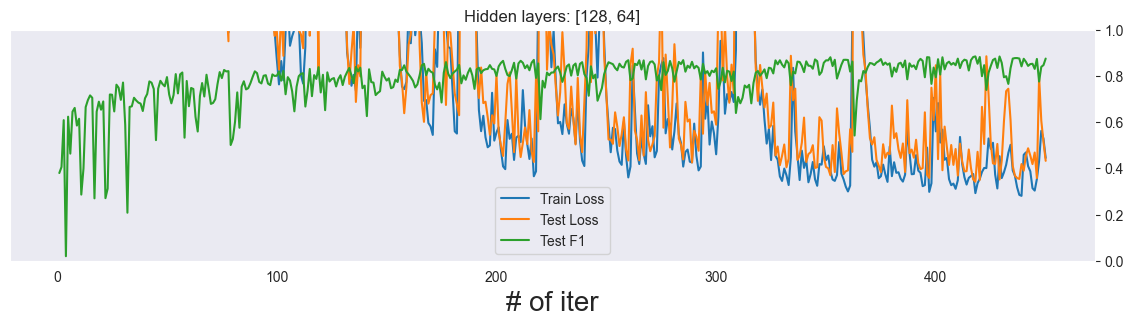

In [108]:
train_loss_history = []
test_loss_history = []
test_f1_history = []

train_dataset = TensorDataset(train_features_torch, train_target_torch)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_features_torch, test_target_torch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = ResNetXavier(input_size=input_size, hidden_layers_size=64, num_layers=16, output_size=output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 450

train_loss_history = []
test_loss_history = []
test_f1_history = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for features, target in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    model.eval()
    test_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for features, target in test_loader:
            outputs = model(features)
            loss = criterion(outputs, target)
            test_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_f1 = f1_score(all_targets, all_preds, average='weighted')
    
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_f1_history.append(test_f1)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test F1 Score: {test_f1:.4f}")
visualize_descent(train_loss_history, test_loss_history, test_f1_history, title=f"Оптимальный ResNet с большим числом слоёв")

In [113]:
layer_means = []
with torch.no_grad():
    model.eval()
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        x = model.input_layer(inputs)
        x = model.relu(x)
        
        for i, layer in enumerate(model.layers):  # Проход по всем резидуал слоям
            x = layer(x)
            mean_value = x.mean().item()
            if len(layer_means) <= i:
                layer_means.append(mean_value)
            else:
                layer_means[i] += mean_value

# Среднее значение для каждого слоя
layer_means = [(idx, mean / len(train_loader)) for idx, mean in enumerate(layer_means)]

layer_means.sort(key=lambda x: x[1], reverse=False)

print(layer_means)


[(11, 92.71156120300293), (9, 96.51249885559082), (10, 96.7458381652832), (8, 101.05047798156738), (12, 111.88920211791992), (5, 114.26856231689453), (6, 115.69614028930664), (7, 116.33461952209473), (4, 124.91593360900879), (13, 132.59808349609375), (14, 147.11077499389648), (15, 157.21731567382812), (3, 165.2177505493164), (2, 167.4128875732422), (1, 223.10966873168945), (0, 306.1664352416992)]


In [127]:
# Создание новой модели без слоя с наименьшей средней величиной
class FineTunedResNet(nn.Module):
    def __init__(self, original_model, remove_layer_idx):
        super(FineTunedResNet, self).__init__()
        self.input_layer = original_model.input_layer
        self.relu = nn.ReLU(inplace=True)
        self.layers = nn.Sequential(
            *[layer for i, layer in enumerate(original_model.layers) if i not in remove_layer_idx]
        )
        self.output_layer = original_model.output_layer

    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.layers(x)
        x = self.output_layer(x)
        return x

fine_tuned_model = FineTunedResNet(model, list(map(lambda i: i[0], layer_means[:4]))).to(device)
optimizer = optim.Adam(fine_tuned_model.parameters(), lr=learning_rate)

Дообучение модифицированной модели

Epoch 1/100, Train Loss: 37.2066, Test Loss: 29.5670, Test F1 Score: 0.2804
Epoch 2/100, Train Loss: 22.4485, Test Loss: 19.4416, Test F1 Score: 0.1918
Epoch 3/100, Train Loss: 12.8052, Test Loss: 4.5227, Test F1 Score: 0.5656
Epoch 4/100, Train Loss: 7.6145, Test Loss: 7.8169, Test F1 Score: 0.6586
Epoch 5/100, Train Loss: 6.0093, Test Loss: 2.5031, Test F1 Score: 0.6030
Epoch 6/100, Train Loss: 2.5781, Test Loss: 2.4641, Test F1 Score: 0.6885
Epoch 7/100, Train Loss: 1.9447, Test Loss: 1.7073, Test F1 Score: 0.6680
Epoch 8/100, Train Loss: 1.3987, Test Loss: 1.1725, Test F1 Score: 0.7560
Epoch 9/100, Train Loss: 1.0491, Test Loss: 0.8973, Test F1 Score: 0.7624
Epoch 10/100, Train Loss: 0.9751, Test Loss: 1.0676, Test F1 Score: 0.7173
Epoch 11/100, Train Loss: 0.8415, Test Loss: 0.8025, Test F1 Score: 0.7750
Epoch 12/100, Train Loss: 0.7517, Test Loss: 0.6156, Test F1 Score: 0.8077
Epoch 13/100, Train Loss: 0.6206, Test Loss: 0.6062, Test F1 Score: 0.8023
Epoch 14/100, Train Loss: 0.5

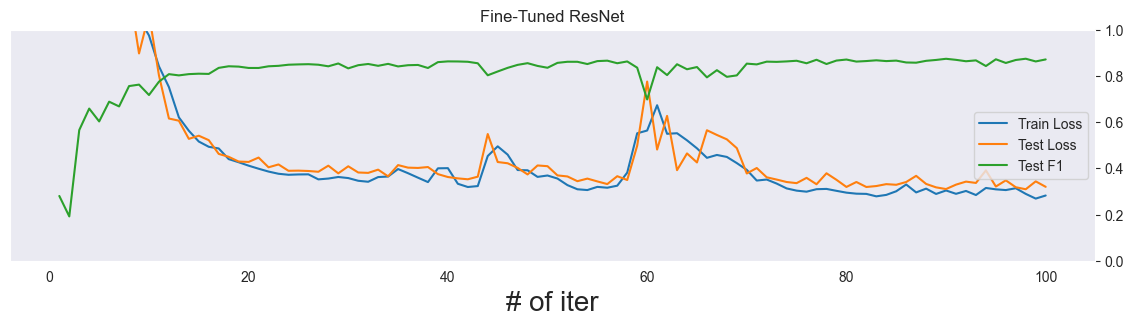

In [128]:
num_epochs_finetune = 100

train_loss_history = []
test_loss_history = []
test_f1_history = []
for epoch in range(num_epochs_finetune):
    fine_tuned_model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = fine_tuned_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    fine_tuned_model.eval()
    test_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for features, target in test_loader:
            outputs = fine_tuned_model(features)
            loss = criterion(outputs, target)
            test_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_f1 = f1_score(all_targets, all_preds, average='weighted')
    
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_f1_history.append(test_f1)
    print(f"Epoch {epoch+1}/{num_epochs_finetune}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test F1 Score: {test_f1:.4f}")
visualize_descent(train_loss_history, test_loss_history, test_f1_history, title=f"Fine-Tuned ResNet")

In [119]:
torch.save(fine_tuned_model.state_dict(), 'models/finetuned_resnet_model.pt')

## Обучение этой же модели, но с нуля

Epoch 1/550, Train Loss: 4843.3844, Test Loss: 1251.4925, Test F1 Score: 0.1918
Epoch 2/550, Train Loss: 864.3828, Test Loss: 636.9749, Test F1 Score: 0.3733
Epoch 3/550, Train Loss: 465.5634, Test Loss: 308.7658, Test F1 Score: 0.4307
Epoch 4/550, Train Loss: 191.4565, Test Loss: 253.4252, Test F1 Score: 0.0242
Epoch 5/550, Train Loss: 220.5842, Test Loss: 114.1300, Test F1 Score: 0.6262
Epoch 6/550, Train Loss: 193.6413, Test Loss: 295.6036, Test F1 Score: 0.4229
Epoch 7/550, Train Loss: 215.2558, Test Loss: 176.7058, Test F1 Score: 0.3868
Epoch 8/550, Train Loss: 197.6054, Test Loss: 105.4613, Test F1 Score: 0.6709
Epoch 9/550, Train Loss: 101.4402, Test Loss: 128.2092, Test F1 Score: 0.4432
Epoch 10/550, Train Loss: 74.9319, Test Loss: 81.7689, Test F1 Score: 0.6336
Epoch 11/550, Train Loss: 84.0002, Test Loss: 49.5843, Test F1 Score: 0.6621
Epoch 12/550, Train Loss: 78.1466, Test Loss: 79.2354, Test F1 Score: 0.3031
Epoch 13/550, Train Loss: 50.3186, Test Loss: 53.4837, Test F1 Sc

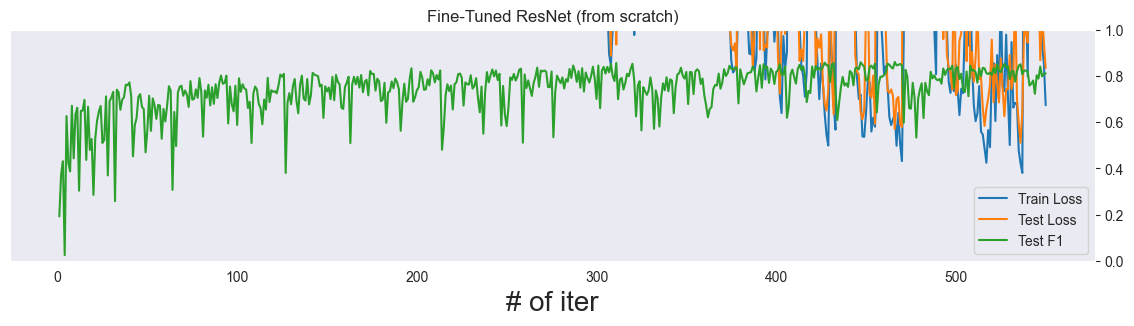

In [129]:
fine_tuned_model = FineTunedResNet(ResNetXavier(input_size=input_size, hidden_layers_size=64, num_layers=16, output_size=output_size).to(device), list(map(lambda i: i[0], layer_means[:4]))).to(device)

num_epochs_finetune = 450 + 100
optimizer = optim.Adam(fine_tuned_model.parameters(), lr=learning_rate)

train_loss_history = []
test_loss_history = []
test_f1_history = []
for epoch in range(num_epochs_finetune):
    fine_tuned_model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = fine_tuned_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    fine_tuned_model.eval()
    test_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for features, target in test_loader:
            outputs = fine_tuned_model(features)
            loss = criterion(outputs, target)
            test_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_f1 = f1_score(all_targets, all_preds, average='weighted')
    
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_f1_history.append(test_f1)
    print(f"Epoch {epoch+1}/{num_epochs_finetune}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test F1 Score: {test_f1:.4f}")
visualize_descent(train_loss_history, test_loss_history, test_f1_history, title=f"Fine-Tuned ResNet (from scratch)")